In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
X.shape

(4730, 10, 4)

In [9]:
v = X.reshape(X.shape[0],10, 4)
v[0]

array([[1.        , 1.        , 1.        , 1.        ],
       [0.53846097, 0.87493207, 0.74074033, 0.5940743 ],
       [0.30769219, 0.72308716, 0.76603403, 0.40893367],
       [0.        , 0.5332453 , 0.        , 0.        ],
       [0.07692195, 0.38794909, 0.07407297, 0.25507595],
       [0.23076878, 0.29568514, 0.22222174, 0.40321853],
       [0.46153756, 0.26363384, 0.47187844, 0.6668672 ],
       [0.07692195, 0.15981632, 0.08779045, 0.43059107],
       [0.        , 0.05663151, 0.03555584, 0.29613476],
       [0.15384536, 0.        , 0.20148095, 0.40321853]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4730,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2919 - accuracy: 0.4625 - mse: 0.4639 - weighted_accuracy: 0.3496 - weighted_mse: 0.5331 - val_loss: 0.3002 - val_accuracy: 0.0455 - val_mse: 0.3519 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3519
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2070 - accuracy: 0.2968 - mse: 0.7989 - weighted_accuracy: 0.4647 - weighted_mse: 0.7655 - val_loss: 0.2914 - val_accuracy: 0.0455 - val_mse: 0.3829 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3829
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1853 - accuracy: 0.2265 - mse: 1.0643 - weighted_accuracy: 0.5148 - weighted_mse: 1.0123 - val_loss: 0.2796 - val_accuracy: 0.0455 - val_mse: 0.4207 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4207
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1763 - accuracy: 0.2244 - mse: 1.2137 - weighted_accuracy: 0.5344 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1339 - accuracy: 0.4062 - mse: 1.6872 - weighted_accuracy: 0.7085 - weighted_mse: 1.6302 - val_loss: 0.1889 - val_accuracy: 0.4101 - val_mse: 1.6236 - val_weighted_accuracy: 0.4101 - val_weighted_mse: 1.6236
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1332 - accuracy: 0.4363 - mse: 1.6768 - weighted_accuracy: 0.7158 - weighted_mse: 1.6253 - val_loss: 0.1810 - val_accuracy: 0.4397 - val_mse: 1.5973 - val_weighted_accuracy: 0.4397 - val_weighted_mse: 1.5973
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.4873 - mse: 1.6625 - weighted_accuracy: 0.7345 - weighted_mse: 1.6293 - val_loss: 0.1847 - val_accuracy: 0.4408 - val_mse: 1.7210 - val_weighted_accuracy: 0.4408 - val_weighted_mse: 1.7210
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1306 - accuracy: 0.4331 - mse: 1.7468 - weighted_accuracy: 0.7110 - weig

30/30 [==============================] - 0s 6ms/step - loss: 0.1081 - accuracy: 0.6134 - mse: 2.1367 - weighted_accuracy: 0.8139 - weighted_mse: 2.1802 - val_loss: 0.1739 - val_accuracy: 0.5402 - val_mse: 2.1783 - val_weighted_accuracy: 0.5402 - val_weighted_mse: 2.1783
Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1078 - accuracy: 0.6028 - mse: 2.1301 - weighted_accuracy: 0.8138 - weighted_mse: 2.1753 - val_loss: 0.1706 - val_accuracy: 0.5666 - val_mse: 2.1735 - val_weighted_accuracy: 0.5666 - val_weighted_mse: 2.1735
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1080 - accuracy: 0.5835 - mse: 2.1845 - weighted_accuracy: 0.8067 - weighted_mse: 2.1983 - val_loss: 0.1660 - val_accuracy: 0.5825 - val_mse: 2.1627 - val_weighted_accuracy: 0.5825 - val_weighted_mse: 2.1627
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1056 - accuracy: 0.6205 - mse: 2.2021 - weighted_accuracy: 0.8222 - weighted_mse: 2.2

Epoch 87/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0840 - accuracy: 0.7112 - mse: 2.8048 - weighted_accuracy: 0.8774 - weighted_mse: 2.9402 - val_loss: 0.1514 - val_accuracy: 0.6776 - val_mse: 2.9787 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 2.9787
Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0843 - accuracy: 0.7260 - mse: 2.8211 - weighted_accuracy: 0.8774 - weighted_mse: 2.9576 - val_loss: 0.1609 - val_accuracy: 0.6469 - val_mse: 2.8530 - val_weighted_accuracy: 0.6469 - val_weighted_mse: 2.8530
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.7207 - mse: 2.8676 - weighted_accuracy: 0.8847 - weighted_mse: 3.0026 - val_loss: 0.1676 - val_accuracy: 0.6427 - val_mse: 2.9262 - val_weighted_accuracy: 0.6427 - val_weighted_mse: 2.9262
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0821 - accuracy: 0.7497 - mse: 2.9382 - weighted_accuracy: 0.8972 - weig

Epoch 116/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.7775 - mse: 3.7427 - weighted_accuracy: 0.8981 - weighted_mse: 3.8829 - val_loss: 0.2074 - val_accuracy: 0.5899 - val_mse: 4.1801 - val_weighted_accuracy: 0.5899 - val_weighted_mse: 4.1801
Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0658 - accuracy: 0.7997 - mse: 3.8707 - weighted_accuracy: 0.9155 - weighted_mse: 4.0313 - val_loss: 0.1951 - val_accuracy: 0.6216 - val_mse: 3.8308 - val_weighted_accuracy: 0.6216 - val_weighted_mse: 3.8308
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0649 - accuracy: 0.8076 - mse: 3.8642 - weighted_accuracy: 0.9202 - weighted_mse: 4.0015 - val_loss: 0.1848 - val_accuracy: 0.6617 - val_mse: 4.0129 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 4.0129
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.7941 - mse: 3.9268 - weighted_accuracy: 0.9061 - 

Epoch 145/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0511 - accuracy: 0.8533 - mse: 5.1299 - weighted_accuracy: 0.9407 - weighted_mse: 5.1986 - val_loss: 0.1993 - val_accuracy: 0.6691 - val_mse: 5.3067 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 5.3067
Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 0.8517 - mse: 5.2070 - weighted_accuracy: 0.9420 - weighted_mse: 5.2909 - val_loss: 0.1753 - val_accuracy: 0.7241 - val_mse: 5.5381 - val_weighted_accuracy: 0.7241 - val_weighted_mse: 5.5381
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0491 - accuracy: 0.8589 - mse: 5.2318 - weighted_accuracy: 0.9427 - weighted_mse: 5.2478 - val_loss: 0.1950 - val_accuracy: 0.6913 - val_mse: 5.6954 - val_weighted_accuracy: 0.6913 - val_weighted_mse: 5.6954
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0505 - accuracy: 0.8576 - mse: 5.2206 - weighted_accuracy: 0.9386 - 

Epoch 174/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0419 - accuracy: 0.8787 - mse: 6.6102 - weighted_accuracy: 0.9555 - weighted_mse: 6.4849 - val_loss: 0.1961 - val_accuracy: 0.7706 - val_mse: 7.4329 - val_weighted_accuracy: 0.7706 - val_weighted_mse: 7.4329
Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0356 - accuracy: 0.9120 - mse: 6.6723 - weighted_accuracy: 0.9659 - weighted_mse: 6.4522 - val_loss: 0.1990 - val_accuracy: 0.7431 - val_mse: 7.0913 - val_weighted_accuracy: 0.7431 - val_weighted_mse: 7.0913
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.9027 - mse: 6.8672 - weighted_accuracy: 0.9588 - weighted_mse: 6.5953 - val_loss: 0.1970 - val_accuracy: 0.7495 - val_mse: 6.8892 - val_weighted_accuracy: 0.7495 - val_weighted_mse: 6.8892
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0403 - accuracy: 0.8853 - mse: 6.8909 - weighted_accuracy: 0.9468 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21451260149478912
Test accuracy: 0.7780126929283142


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.005244   -3.9738746   1.62764   ]
 [-1.6578925  -3.256875    0.5374116 ]
 [-0.5116902  -4.685468    0.3610261 ]
 ...
 [-1.1023371  -1.9764494  -0.27483618]
 [-2.8355432  -4.222724    2.3177445 ]
 [-1.4147456  -3.3992105   0.28653148]]


Counter({2: 809, 1: 69, 0: 68})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 43, 1: 43})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 946
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 39
actual holds but predicted buy: 64
actual holds but predicted sell: 65
actual predicted holds: 731
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 85.0%
actual buys: 43
actual sells: 43
actual holds: 860


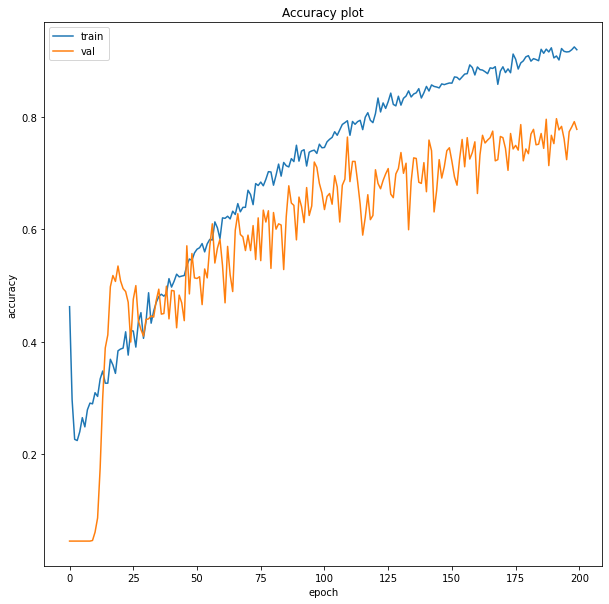

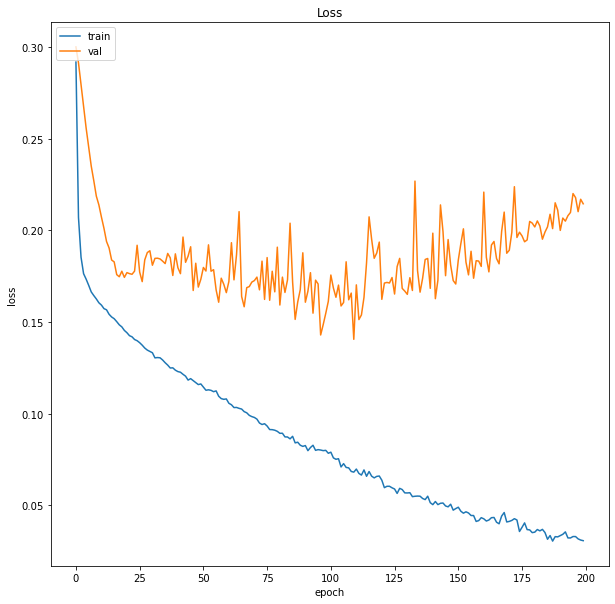

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_10.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [23]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-28         9.72  9.602493 -20.000000  7026900.0     0.0
2019-01-29         9.75  9.625186 -15.000083  7689700.0     2.0
2019-01-30         9.64  9.627465 -51.515038  6232300.0     2.0
2019-01-31         9.66  9.632471 -45.454598  7395400.0     2.0
2019-02-01         9.65  9.635167 -48.484962  5664000.0     2.0


In [25]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [26]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(218, 10, 4)

In [27]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [28]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.7661 - mean_squared_error: 8.2597 - weighted_accuracy: 0.7661 - weighted_mean_squared_error: 8.2597
Test loss: 0.18450745940208435
Test accuracy: 0.7660550475120544


In [29]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 0: 20, 1: 21})

In [30]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [31]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2
2019-02-15,9.76,9.706131,-6.250130,8384988.0,2.0,0,2


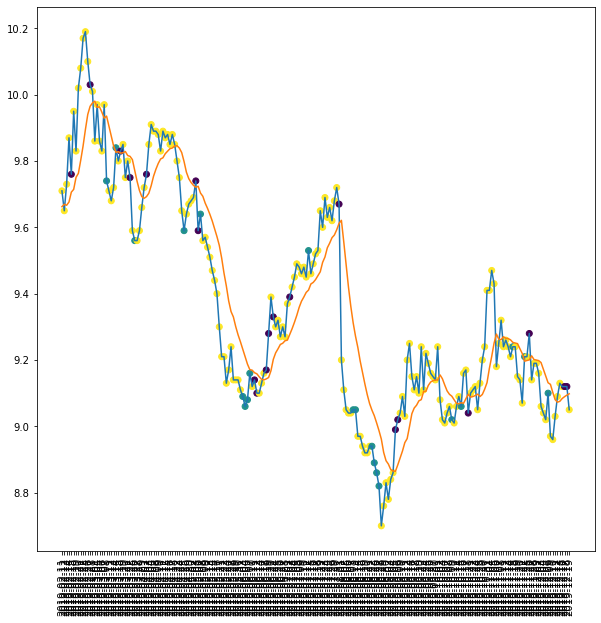

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 19
actual predicted holds: 163
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 81.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 45.0%
Percentage holds correct: 80.68181818181819%


In [35]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 45.0%
Percentage holds correct: 80.68181818181819%


In [36]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.739999771118164
Shares owned at the moment: 1023
Cash capital at the moment: $8.579179790020135


Stop Loss Activated!

Share price: $9.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9669.747974709271


Share price: $9.09000015258789
Shares owned at the moment: 1060
Cash capital at the moment: $7.850462521313602


Price increase from previously bought: 6.088892662559386%
Share price: $9.670000076293944
Shares owned at the moment: 0
Cash capital at the moment: $10229.862493170496


Share price: $9.050000190734863
Shares owned at the moment: 1127
Cash capital at the moment: $2.464065121170279


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $9780.400375754116


Share price: $9.020000457763672
Shares owned at the moment: 1081
Cash capital at the moment: $2.9656745507691085




Capital at the end of test period: $9759.11249266815
profit gained: -2.4088750733185043%


In [37]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [38]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-30         8.57  8.828210 -85.245891 -3263600.0     2.0
2020-01-31         8.54  8.783870 -90.163875 -5360700.0     2.0
2020-02-03         8.55  8.747890 -88.524495 -2703900.0     1.0
2020-02-04         8.49  8.708214 -96.774273 -5257100.0     2.0
2020-02-05         8.55  8.683874 -87.096784 -3170600.0     2.0


In [39]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [40]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(215, 10, 4)

In [41]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [42]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.7674 - mean_squared_error: 8.1810 - weighted_accuracy: 0.7674 - weighted_mean_squared_error: 8.1810
Test loss: 0.17135760188102722
Test accuracy: 0.7674418687820435


In [43]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 24, 0: 15, 2: 176})

In [44]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [45]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,1,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,0,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,0,2
2020-02-18,8.51,8.626740,-32.258144,341600.0,2.0,2,2


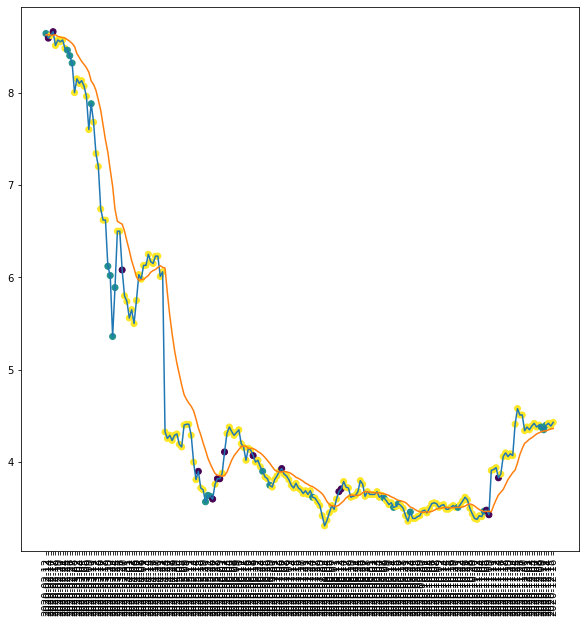

In [46]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [47]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 22
actual holds but predicted sell: 14
actual predicted holds: 162
Percentage buys correct: 25.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 81.81818181818181%
actual buys: 8
actual sells: 9
actual holds: 198


In [48]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 50.0%
Percentage sells correct: 60.0%
Percentage holds correct: 85.14285714285714%


In [49]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.640000343322754
Shares owned at the moment: 1154
Cash capital at the moment: $2.0205627160066797


Stop Loss Activated!

Share price: $8.399999618530272
Shares owned at the moment: 0
Cash capital at the moment: $9668.962723710534


Share price: $8.399999618530272
Shares owned at the moment: 1147
Cash capital at the moment: $7.667462459563467


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9158.433462459563


Share price: $7.880000114440918
Shares owned at the moment: 1159
Cash capital at the moment: $0.39779945778718684


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8484.063560820818


Share price: $6.119999885559082
Shares owned at the moment: 1382
Cash capital at the moment: $2.9646594130990707


Stop Loss Activated!

Share price: $5.360000133514403
Shares owned at the moment: 0
Cash capital at the moment: $7390.114163422583


Share price: $5.36000

In [50]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [51]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [52]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [53]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [54]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
X.shape

(4794, 10, 4)

In [55]:
y = labels
y = np.array(y)

In [56]:
X[0]

array([[0.09090868, 0.95499514, 0.        , 0.20346518],
       [0.27272695, 0.75077853, 0.15942005, 0.51011961],
       [0.09090868, 0.42280906, 0.05590073, 0.25758971],
       [0.        , 0.06771143, 0.04347991, 0.        ],
       [0.27272695, 0.        , 0.30434872, 0.13799446],
       [0.90909132, 0.48580386, 0.91304402, 0.66712664],
       [1.        , 0.97445367, 1.        , 1.        ],
       [0.54545479, 1.        , 0.56521838, 0.5502913 ],
       [0.09090868, 0.63368877, 0.1304359 , 0.36568534],
       [0.27272695, 0.47890391, 0.30434872, 0.56409075]])

In [57]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [58]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [59]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [61]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2921 - accuracy: 0.4576 - mse: 0.4631 - weighted_accuracy: 0.3154 - weighted_mse: 0.5347 - val_loss: 0.2999 - val_accuracy: 0.0417 - val_mse: 0.3519 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3519
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2069 - accuracy: 0.2615 - mse: 0.7978 - weighted_accuracy: 0.4733 - weighted_mse: 0.7443 - val_loss: 0.2912 - val_accuracy: 0.0417 - val_mse: 0.3853 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3853
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1827 - accuracy: 0.2209 - mse: 1.0586 - weighted_accuracy: 0.5260 - weighted_mse: 0.9892 - val_loss: 0.2795 - val_accuracy: 0.0417 - val_mse: 0.4239 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.4239
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1735 - accuracy: 0.2287 - mse: 1.2238 - weighted_accuracy: 0.5418 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.3797 - mse: 1.9555 - weighted_accuracy: 0.7359 - weighted_mse: 1.8959 - val_loss: 0.1957 - val_accuracy: 0.3003 - val_mse: 1.9580 - val_weighted_accuracy: 0.3003 - val_weighted_mse: 1.9580
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1300 - accuracy: 0.3716 - mse: 2.0055 - weighted_accuracy: 0.7344 - weighted_mse: 1.9361 - val_loss: 0.1913 - val_accuracy: 0.3274 - val_mse: 2.0677 - val_weighted_accuracy: 0.3274 - val_weighted_mse: 2.0677
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1296 - accuracy: 0.3734 - mse: 1.9987 - weighted_accuracy: 0.7281 - weighted_mse: 1.9292 - val_loss: 0.1896 - val_accuracy: 0.3681 - val_mse: 2.0509 - val_weighted_accuracy: 0.3681 - val_weighted_mse: 2.0509
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1281 - accuracy: 0.3924 - mse: 2.0197 - weighted_accuracy: 0.7390 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1083 - accuracy: 0.5515 - mse: 2.6363 - weighted_accuracy: 0.8028 - weighted_mse: 2.6427 - val_loss: 0.1667 - val_accuracy: 0.5141 - val_mse: 2.6520 - val_weighted_accuracy: 0.5141 - val_weighted_mse: 2.6520
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1069 - accuracy: 0.5755 - mse: 2.6323 - weighted_accuracy: 0.8168 - weighted_mse: 2.6706 - val_loss: 0.1979 - val_accuracy: 0.4223 - val_mse: 2.8498 - val_weighted_accuracy: 0.4223 - val_weighted_mse: 2.8498
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1061 - accuracy: 0.5528 - mse: 2.6695 - weighted_accuracy: 0.8105 - weighted_mse: 2.7071 - val_loss: 0.1895 - val_accuracy: 0.4432 - val_mse: 2.6463 - val_weighted_accuracy: 0.4432 - val_weighted_mse: 2.6463
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1048 - accuracy: 0.5877 - mse: 2.6488 - weighted_accuracy: 0.8229 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0853 - accuracy: 0.6892 - mse: 3.4992 - weighted_accuracy: 0.8657 - weighted_mse: 3.6044 - val_loss: 0.1838 - val_accuracy: 0.5308 - val_mse: 3.5615 - val_weighted_accuracy: 0.5308 - val_weighted_mse: 3.5615
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0870 - accuracy: 0.6774 - mse: 3.5040 - weighted_accuracy: 0.8557 - weighted_mse: 3.6321 - val_loss: 0.1843 - val_accuracy: 0.5714 - val_mse: 3.4299 - val_weighted_accuracy: 0.5714 - val_weighted_mse: 3.4299
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0861 - accuracy: 0.6876 - mse: 3.5819 - weighted_accuracy: 0.8707 - weighted_mse: 3.6737 - val_loss: 0.2035 - val_accuracy: 0.4974 - val_mse: 3.6345 - val_weighted_accuracy: 0.4974 - val_weighted_mse: 3.6345
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0848 - accuracy: 0.7134 - mse: 3.5299 - weighted_accuracy: 0.8787 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0668 - accuracy: 0.7815 - mse: 4.7487 - weighted_accuracy: 0.9072 - weighted_mse: 4.8184 - val_loss: 0.1873 - val_accuracy: 0.6017 - val_mse: 4.4893 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 4.4893
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0666 - accuracy: 0.7812 - mse: 4.7325 - weighted_accuracy: 0.9055 - weighted_mse: 4.7928 - val_loss: 0.1664 - val_accuracy: 0.6747 - val_mse: 4.5234 - val_weighted_accuracy: 0.6747 - val_weighted_mse: 4.5234
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0656 - accuracy: 0.7974 - mse: 4.8526 - weighted_accuracy: 0.9078 - weighted_mse: 4.9291 - val_loss: 0.1918 - val_accuracy: 0.6038 - val_mse: 4.9992 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 4.9992
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0678 - accuracy: 0.7760 - mse: 4.8518 - weighted_accuracy: 0.8996 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0494 - accuracy: 0.8555 - mse: 6.4275 - weighted_accuracy: 0.9436 - weighted_mse: 6.2379 - val_loss: 0.1831 - val_accuracy: 0.7143 - val_mse: 6.5700 - val_weighted_accuracy: 0.7143 - val_weighted_mse: 6.5700
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0518 - accuracy: 0.8493 - mse: 6.4449 - weighted_accuracy: 0.9338 - weighted_mse: 6.3020 - val_loss: 0.2195 - val_accuracy: 0.6225 - val_mse: 6.9044 - val_weighted_accuracy: 0.6225 - val_weighted_mse: 6.9044
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0483 - accuracy: 0.8615 - mse: 6.5902 - weighted_accuracy: 0.9476 - weighted_mse: 6.3907 - val_loss: 0.1815 - val_accuracy: 0.7247 - val_mse: 6.4266 - val_weighted_accuracy: 0.7247 - val_weighted_mse: 6.4266
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0490 - accuracy: 0.8600 - mse: 6.5289 - weighted_accuracy: 0.9416 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.8962 - mse: 8.4245 - weighted_accuracy: 0.9585 - weighted_mse: 7.8784 - val_loss: 0.2017 - val_accuracy: 0.7278 - val_mse: 8.5516 - val_weighted_accuracy: 0.7278 - val_weighted_mse: 8.5516
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9014 - mse: 8.5734 - weighted_accuracy: 0.9566 - weighted_mse: 8.0482 - val_loss: 0.1956 - val_accuracy: 0.7424 - val_mse: 9.0604 - val_weighted_accuracy: 0.7424 - val_weighted_mse: 9.0604
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.8991 - mse: 8.6327 - weighted_accuracy: 0.9574 - weighted_mse: 8.0374 - val_loss: 0.1993 - val_accuracy: 0.7487 - val_mse: 8.7894 - val_weighted_accuracy: 0.7487 - val_weighted_mse: 8.7894
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0377 - accuracy: 0.9043 - mse: 8.4992 - weighted_accuracy: 0.9557 - 

In [62]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22572970390319824
Test accuracy: 0.7340980172157288


In [63]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.8192209  -2.3079393   0.10680056]
 [-4.0309396  -1.9722896   0.91315913]
 [-4.644077    0.24715222 -1.2409446 ]
 ...
 [-2.850175   -1.862687    0.9766984 ]
 [-2.0832405  -4.624486    1.771302  ]
 [ 0.43739784 -4.6805673  -1.1602489 ]]


Counter({2: 764, 1: 75, 0: 120})

In [64]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 875, 1: 40, 0: 44})

In [65]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 959
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 38
actual holds but predicted buy: 68
actual holds but predicted sell: 114
actual predicted holds: 693
Percentage buys correct: 15.0%
Percentage sells correct: 11.363636363636363%
Percentage holds correct: 79.2%
actual buys: 40
actual sells: 44
actual holds: 875


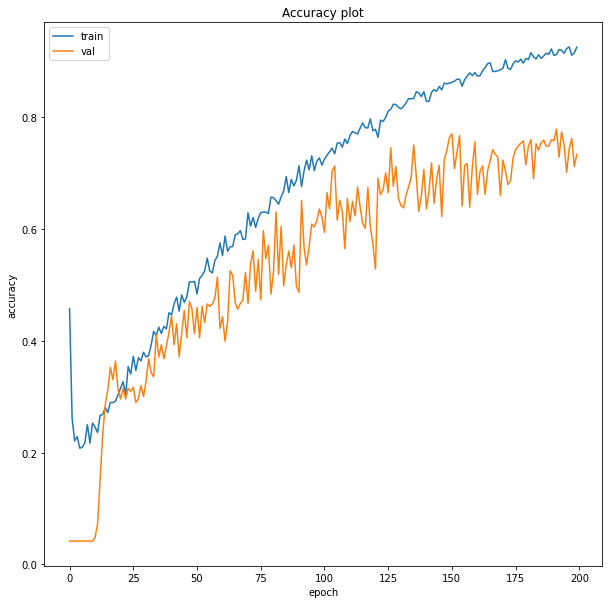

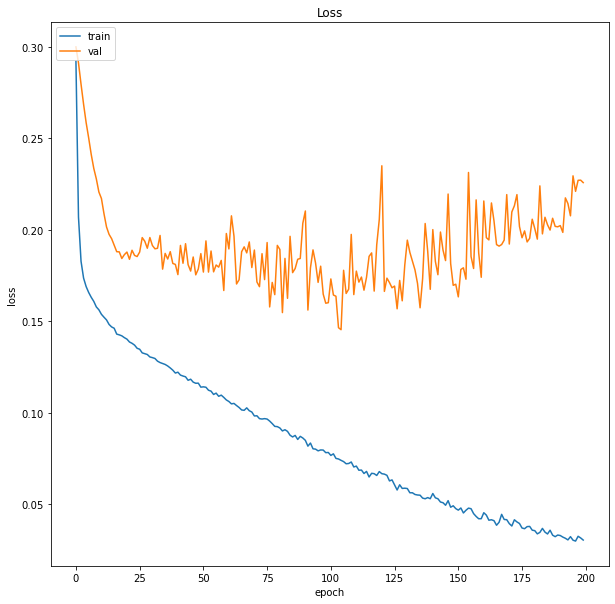

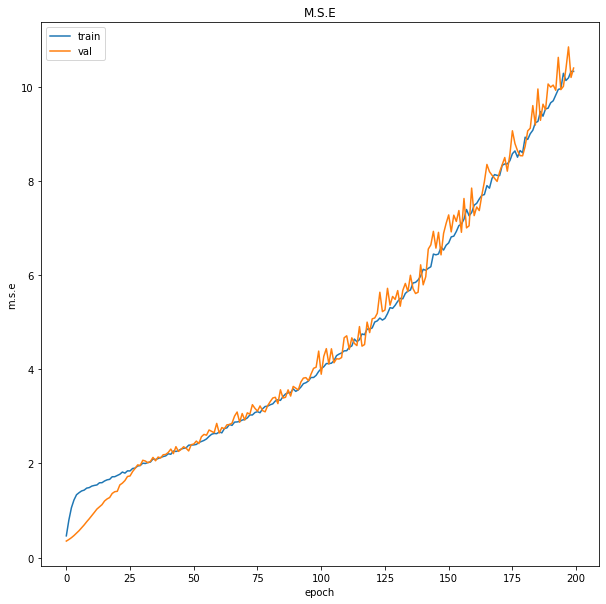

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [68]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-28        11.47  11.498850 -69.642815  18673351.0     2.0
2019-01-29        11.52  11.502104 -60.714201  22001151.0     2.0
2019-01-30        11.40  11.486395 -82.142942  18573051.0     2.0
2019-01-31        11.39  11.471565 -83.928529  15623051.0     2.0
2019-02-01        11.51  11.477478 -62.499957  23129851.0     2.0


In [69]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [70]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(218, 10, 4)

In [71]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [72]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2695 - accuracy: 0.7064 - mean_squared_error: 10.3206 - weighted_accuracy: 0.7064 - weighted_mean_squared_error: 10.3206
Test loss: 0.2695026099681854
Test accuracy: 0.7064220309257507


In [73]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 168, 0: 30, 1: 20})

In [74]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [75]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,2,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,2,2


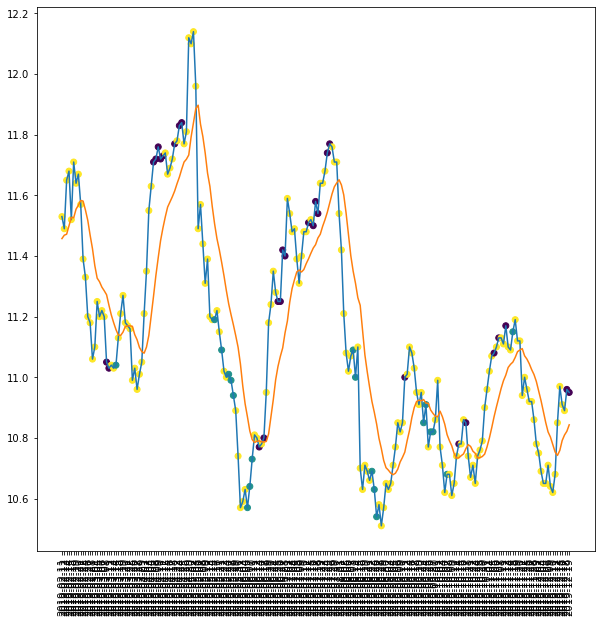

In [76]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

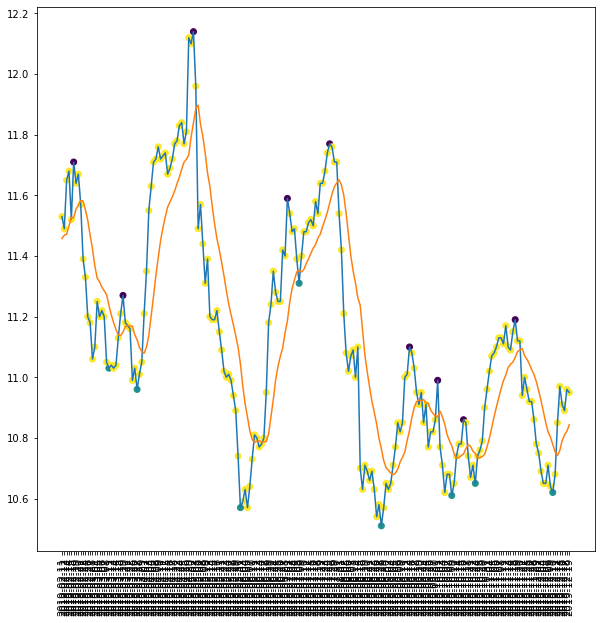

In [77]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [78]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 20
actual holds but predicted sell: 28
actual predicted holds: 153
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 76.11940298507463%
actual buys: 8
actual sells: 9
actual holds: 201


In [79]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 45.0%
Percentage sells correct: 60.0%
Percentage holds correct: 84.4311377245509%


In [80]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.039999961853027
Shares owned at the moment: 903
Cash capital at the moment: $3.4649545414449676


Price increase from previously bought: 5.777951923957536%
Share price: $11.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $10548.516131393433


Share price: $11.1899995803833
Shares owned at the moment: 940
Cash capital at the moment: $0.9903769178399671


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10068.827262360574


Share price: $10.56999969482422
Shares owned at the moment: 949
Cash capital at the moment: $10.312495268819475


Price increase from previously bought: 6.1414159765344145%
Share price: $11.25
Shares owned at the moment: 0
Cash capital at the moment: $10657.20280776882


Share price: $11.09000015258789
Shares owned at the moment: 958
Cash capital at the moment: $3.7660561876273277


Stop Loss Activated!

Share price: $10.699999809265137
Shares owned at the momen

In [81]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


### recession

In [82]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df = df.iloc[5:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-30        10.91  11.040970 -69.565290  19391135.0     2.0
2020-01-31        10.92  11.022359 -67.391322  24795035.0     2.0
2020-02-03        10.83  10.992765 -83.333333  15850435.0     1.0
2020-02-04        10.71  10.949263 -98.113163   8263935.0     2.0
2020-02-05        10.85  10.933992 -71.697991  14379935.0     2.0


In [83]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [84]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(215, 10, 4)

In [85]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [86]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.7442 - mean_squared_error: 11.0771 - weighted_accuracy: 0.7442 - weighted_mean_squared_error: 11.0771
Test loss: 0.2840029299259186
Test accuracy: 0.7441860437393188


In [87]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 172, 0: 28, 1: 15})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [89]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,2,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,0,2


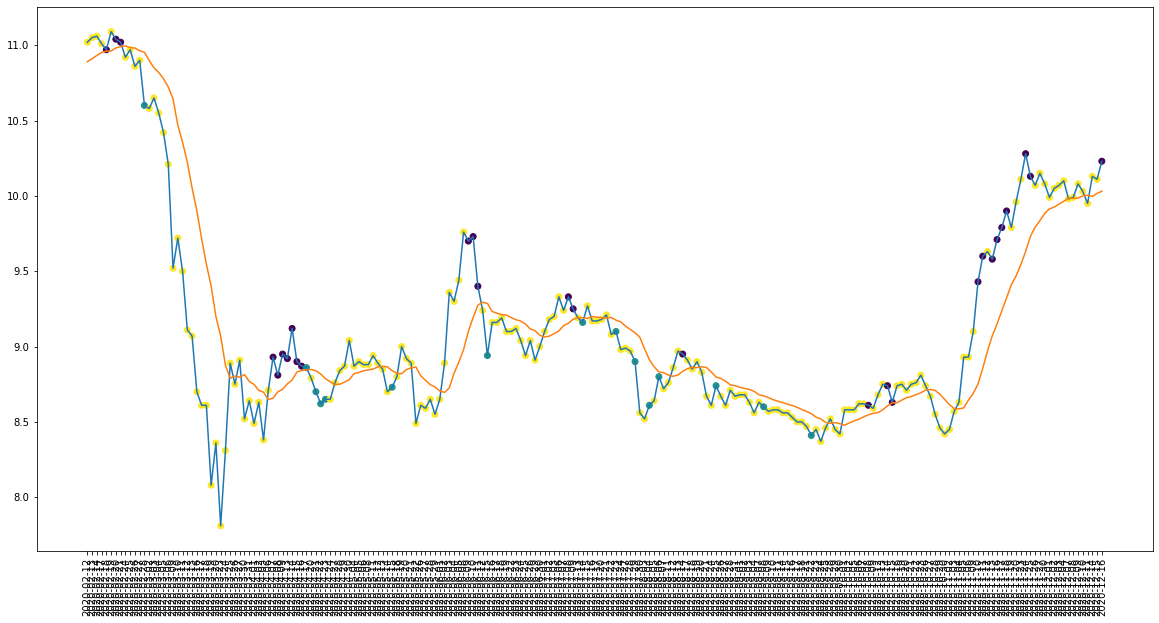

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

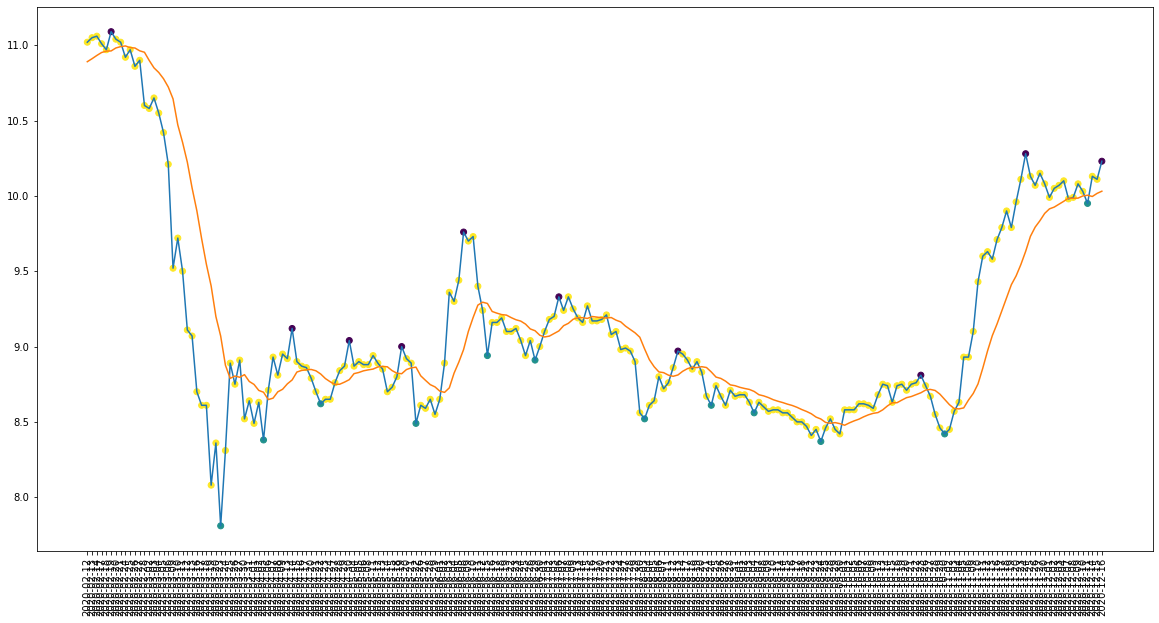

In [91]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [92]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 13
actual holds but predicted sell: 25
actual predicted holds: 155
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 30.0%
Percentage holds correct: 80.31088082901555%
actual buys: 12
actual sells: 10
actual holds: 193


In [93]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 60.0%
Percentage sells correct: 67.85714285714286%
Percentage holds correct: 86.54970760233918%


In [94]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.600000381469727
Shares owned at the moment: 940
Cash capital at the moment: $8.59864043235757


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9579.605826191902


Share price: $8.859999656677246
Shares owned at the moment: 1078
Cash capital at the moment: $2.260727311611845


Stop Loss Activated!

Share price: $8.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9129.311876255513


Share price: $8.9399995803833
Shares owned at the moment: 1018
Cash capital at the moment: $3.3647746000297047


Stop Loss Activated!

Share price: $8.560000419616701
Shares owned at the moment: 0
Cash capital at the moment: $8693.481480595114


Share price: $8.609999656677246
Shares owned at the moment: 1006
Cash capital at the moment: $8.002261927606014


Stop Loss Activated!

Share price: $8.369999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8405.066542116643




Capital at 

In [95]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [96]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


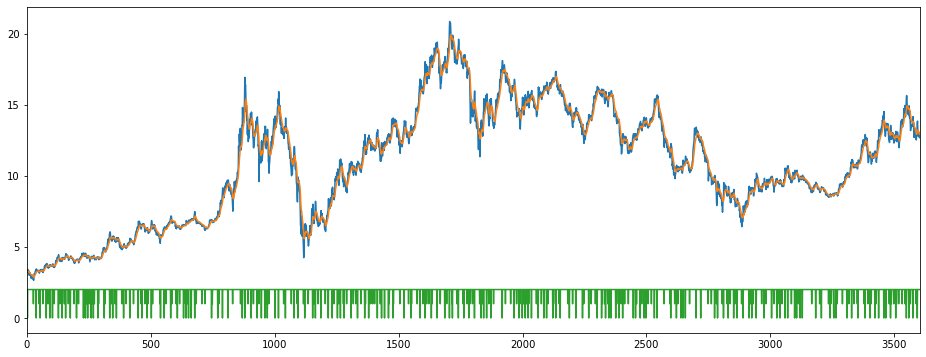

In [97]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [98]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-04-07,3.250,3.264699,-57.142857,31539206.0,2.0
2004-04-08,3.200,3.254745,-78.947368,-24878594.0,2.0
2004-04-13,3.250,3.254015,-52.631579,10937473.0,0.0
2004-04-14,3.375,3.272628,-10.416706,98972973.0,2.0
2004-04-15,3.275,3.272993,-52.083331,47190715.0,2.0


In [99]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [100]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
X.shape

(3595, 10, 4)

In [101]:
y = labels
y = np.array(y)

In [102]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [103]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [104]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [106]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 35ms/step - loss: 0.3009 - accuracy: 0.4955 - mse: 0.4333 - weighted_accuracy: 0.3322 - weighted_mse: 0.5248 - val_loss: 0.3011 - val_accuracy: 0.0459 - val_mse: 0.3469 - val_weighted_accuracy: 0.0459 - val_weighted_mse: 0.3469
Epoch 2/200
23/23 [==============================] - 0s 7ms/step - loss: 0.2190 - accuracy: 0.3202 - mse: 0.6939 - weighted_accuracy: 0.4538 - weighted_mse: 0.6852 - val_loss: 0.2959 - val_accuracy: 0.0445 - val_mse: 0.3662 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.3662
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1911 - accuracy: 0.2410 - mse: 0.9290 - weighted_accuracy: 0.5165 - weighted_mse: 0.8874 - val_loss: 0.2874 - val_accuracy: 0.0445 - val_mse: 0.3888 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.3888
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1793 - accuracy: 0.2472 - mse: 1.1049 - weighted_accuracy: 0.5480 - weighte

Epoch 30/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1356 - accuracy: 0.4621 - mse: 1.6205 - weighted_accuracy: 0.6942 - weighted_mse: 1.5843 - val_loss: 0.1692 - val_accuracy: 0.4993 - val_mse: 1.4907 - val_weighted_accuracy: 0.4993 - val_weighted_mse: 1.4907
Epoch 31/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1342 - accuracy: 0.4277 - mse: 1.6582 - weighted_accuracy: 0.7226 - weighted_mse: 1.6156 - val_loss: 0.1746 - val_accuracy: 0.4604 - val_mse: 1.5200 - val_weighted_accuracy: 0.4604 - val_weighted_mse: 1.5200
Epoch 32/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1323 - accuracy: 0.4409 - mse: 1.6839 - weighted_accuracy: 0.7080 - weighted_mse: 1.6466 - val_loss: 0.1720 - val_accuracy: 0.4840 - val_mse: 1.5880 - val_weighted_accuracy: 0.4840 - val_weighted_mse: 1.5880
Epoch 33/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1316 - accuracy: 0.4604 - mse: 1.6897 - weighted_accuracy: 0.7346 - weig

Epoch 59/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1103 - accuracy: 0.5793 - mse: 2.1233 - weighted_accuracy: 0.8023 - weighted_mse: 2.1821 - val_loss: 0.1741 - val_accuracy: 0.5605 - val_mse: 2.2224 - val_weighted_accuracy: 0.5605 - val_weighted_mse: 2.2224
Epoch 60/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1096 - accuracy: 0.5852 - mse: 2.1464 - weighted_accuracy: 0.8117 - weighted_mse: 2.2203 - val_loss: 0.1762 - val_accuracy: 0.5271 - val_mse: 2.2419 - val_weighted_accuracy: 0.5271 - val_weighted_mse: 2.2419
Epoch 61/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1079 - accuracy: 0.5855 - mse: 2.1691 - weighted_accuracy: 0.8143 - weighted_mse: 2.2417 - val_loss: 0.1724 - val_accuracy: 0.5396 - val_mse: 2.3251 - val_weighted_accuracy: 0.5396 - val_weighted_mse: 2.3251
Epoch 62/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1076 - accuracy: 0.6165 - mse: 2.1559 - weighted_accuracy: 0.8232 - weig

Epoch 88/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0872 - accuracy: 0.7045 - mse: 2.7073 - weighted_accuracy: 0.8795 - weighted_mse: 2.8952 - val_loss: 0.1598 - val_accuracy: 0.6439 - val_mse: 2.8834 - val_weighted_accuracy: 0.6439 - val_weighted_mse: 2.8834
Epoch 89/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0877 - accuracy: 0.7114 - mse: 2.6944 - weighted_accuracy: 0.8699 - weighted_mse: 2.8947 - val_loss: 0.2036 - val_accuracy: 0.5355 - val_mse: 2.8621 - val_weighted_accuracy: 0.5355 - val_weighted_mse: 2.8621
Epoch 90/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0857 - accuracy: 0.7215 - mse: 2.7437 - weighted_accuracy: 0.8786 - weighted_mse: 2.9693 - val_loss: 0.1554 - val_accuracy: 0.6801 - val_mse: 2.9699 - val_weighted_accuracy: 0.6801 - val_weighted_mse: 2.9699
Epoch 91/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0857 - accuracy: 0.7330 - mse: 2.7685 - weighted_accuracy: 0.8851 - weig

Epoch 117/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.7886 - mse: 3.5486 - weighted_accuracy: 0.9176 - weighted_mse: 3.8830 - val_loss: 0.1603 - val_accuracy: 0.6871 - val_mse: 3.8241 - val_weighted_accuracy: 0.6871 - val_weighted_mse: 3.8241
Epoch 118/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0670 - accuracy: 0.7959 - mse: 3.5536 - weighted_accuracy: 0.9180 - weighted_mse: 3.8728 - val_loss: 0.1899 - val_accuracy: 0.5939 - val_mse: 3.9918 - val_weighted_accuracy: 0.5939 - val_weighted_mse: 3.9918
Epoch 119/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0654 - accuracy: 0.8091 - mse: 3.5967 - weighted_accuracy: 0.9204 - weighted_mse: 3.9324 - val_loss: 0.1592 - val_accuracy: 0.6954 - val_mse: 4.0001 - val_weighted_accuracy: 0.6954 - val_weighted_mse: 4.0001
Epoch 120/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0667 - accuracy: 0.7813 - mse: 3.6991 - weighted_accuracy: 0.9126 - 

Epoch 146/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0502 - accuracy: 0.8540 - mse: 4.8597 - weighted_accuracy: 0.9416 - weighted_mse: 5.2359 - val_loss: 0.1812 - val_accuracy: 0.6843 - val_mse: 5.2259 - val_weighted_accuracy: 0.6843 - val_weighted_mse: 5.2259
Epoch 147/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0491 - accuracy: 0.8741 - mse: 4.8091 - weighted_accuracy: 0.9514 - weighted_mse: 5.1207 - val_loss: 0.1859 - val_accuracy: 0.6648 - val_mse: 5.1609 - val_weighted_accuracy: 0.6648 - val_weighted_mse: 5.1609
Epoch 148/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0493 - accuracy: 0.8623 - mse: 4.9246 - weighted_accuracy: 0.9495 - weighted_mse: 5.2168 - val_loss: 0.1617 - val_accuracy: 0.7246 - val_mse: 5.4637 - val_weighted_accuracy: 0.7246 - val_weighted_mse: 5.4637
Epoch 149/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0484 - accuracy: 0.8703 - mse: 5.0158 - weighted_accuracy: 0.9428 - 

Epoch 175/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9044 - mse: 6.4454 - weighted_accuracy: 0.9601 - weighted_mse: 6.6531 - val_loss: 0.1653 - val_accuracy: 0.7983 - val_mse: 7.3735 - val_weighted_accuracy: 0.7983 - val_weighted_mse: 7.3735
Epoch 176/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.8992 - mse: 6.4293 - weighted_accuracy: 0.9606 - weighted_mse: 6.6202 - val_loss: 0.1745 - val_accuracy: 0.7510 - val_mse: 7.0752 - val_weighted_accuracy: 0.7510 - val_weighted_mse: 7.0752
Epoch 177/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9047 - mse: 6.3915 - weighted_accuracy: 0.9651 - weighted_mse: 6.6507 - val_loss: 0.1766 - val_accuracy: 0.7594 - val_mse: 6.9055 - val_weighted_accuracy: 0.7594 - val_weighted_mse: 6.9055
Epoch 178/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9214 - mse: 6.5632 - weighted_accuracy: 0.9712 - 

In [107]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26939159631729126
Test accuracy: 0.681502103805542


In [108]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.17727876 -4.565014   -0.65021694]
 [-2.3691952  -3.5170867   1.468542  ]
 [-2.305754   -2.0491269   0.5897841 ]
 ...
 [-1.4151145  -6.665049    1.3970497 ]
 [-1.2851912  -3.6097896   0.870931  ]
 [-3.2424567  -5.514949    2.4932663 ]]


Counter({0: 78, 2: 517, 1: 124})

In [109]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 654, 0: 33, 1: 32})

In [110]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 719
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 20
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 26
actual holds but predicted buy: 112
actual holds but predicted sell: 71
actual predicted holds: 471
Percentage buys correct: 37.5%
Percentage sells correct: 21.21212121212121%
Percentage holds correct: 72.01834862385321%
actual buys: 32
actual sells: 33
actual holds: 654


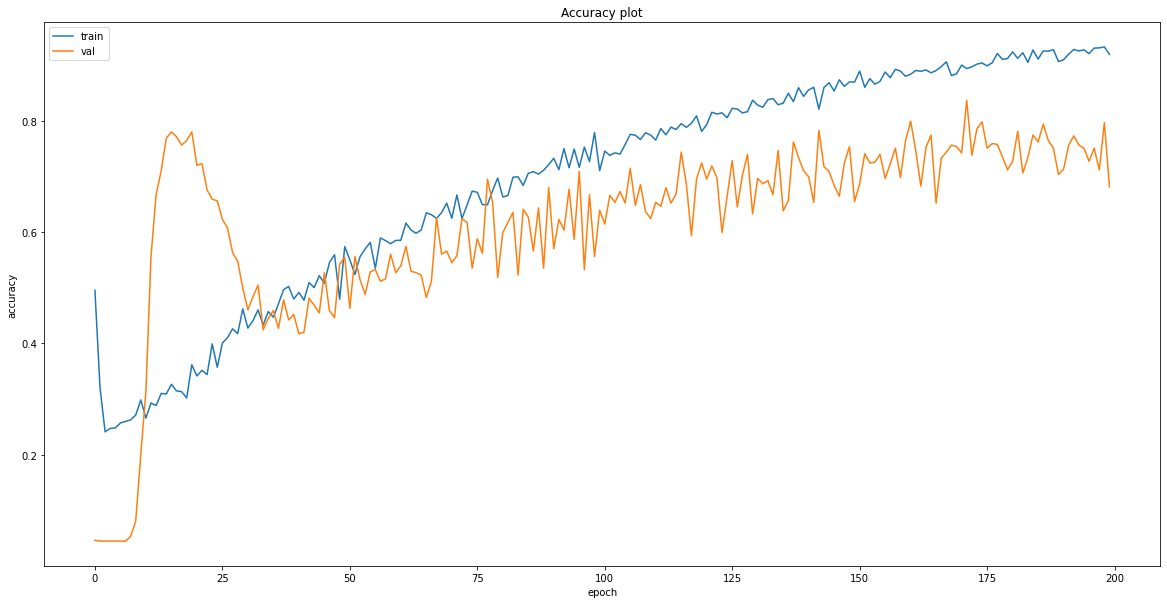

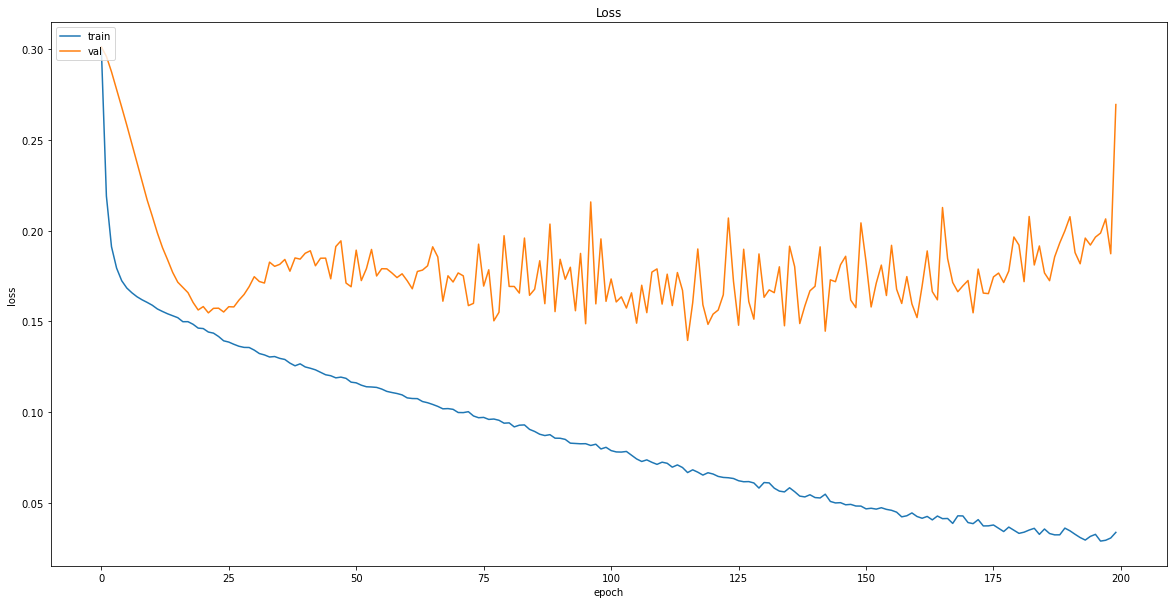

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [112]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [113]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,13.04,12.757552,-13.725518,456517506.0,2.0
2019-01-30,12.64,12.739468,-52.941149,367199487.0,2.0
2019-01-31,12.80,12.748780,-37.254896,419227428.0,2.0
2019-02-01,13.12,12.805891,-5.882391,486899235.0,2.0
2019-02-04,13.22,12.869600,-6.818120,532291174.0,2.0


In [114]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(211, 10, 4)

In [115]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [116]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3216 - accuracy: 0.6588 - mean_squared_error: 8.1327 - weighted_accuracy: 0.6588 - weighted_mean_squared_error: 8.1327
Test loss: 0.321598082780838
Test accuracy: 0.6587677597999573


In [117]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 147, 0: 17, 1: 47})

In [118]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [119]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,2,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,2,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,2,2


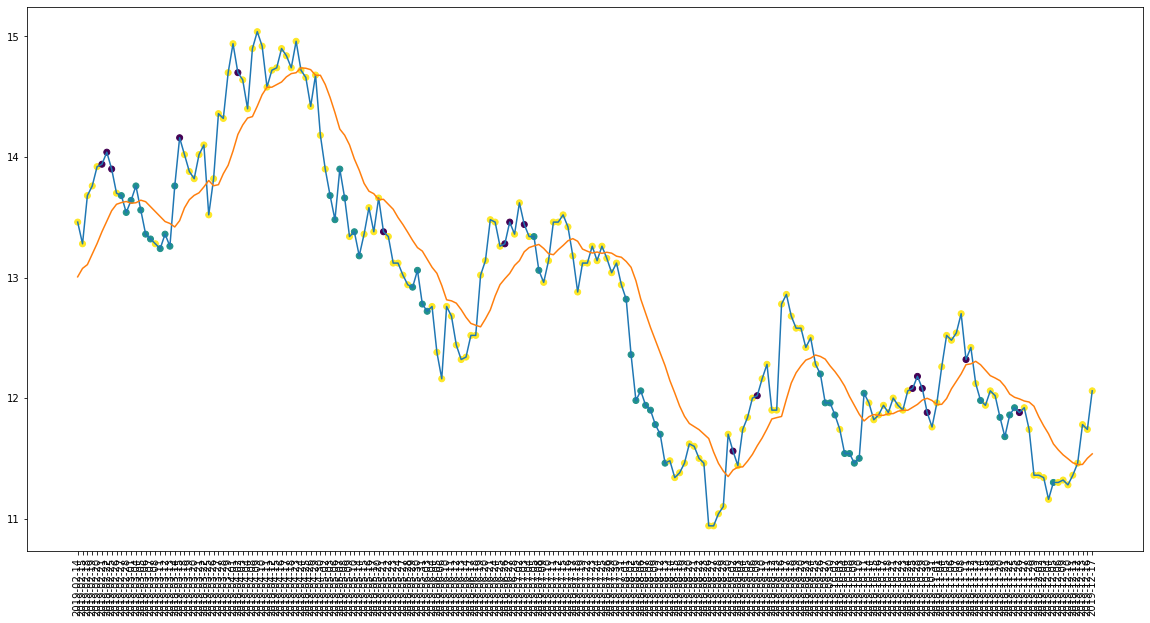

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

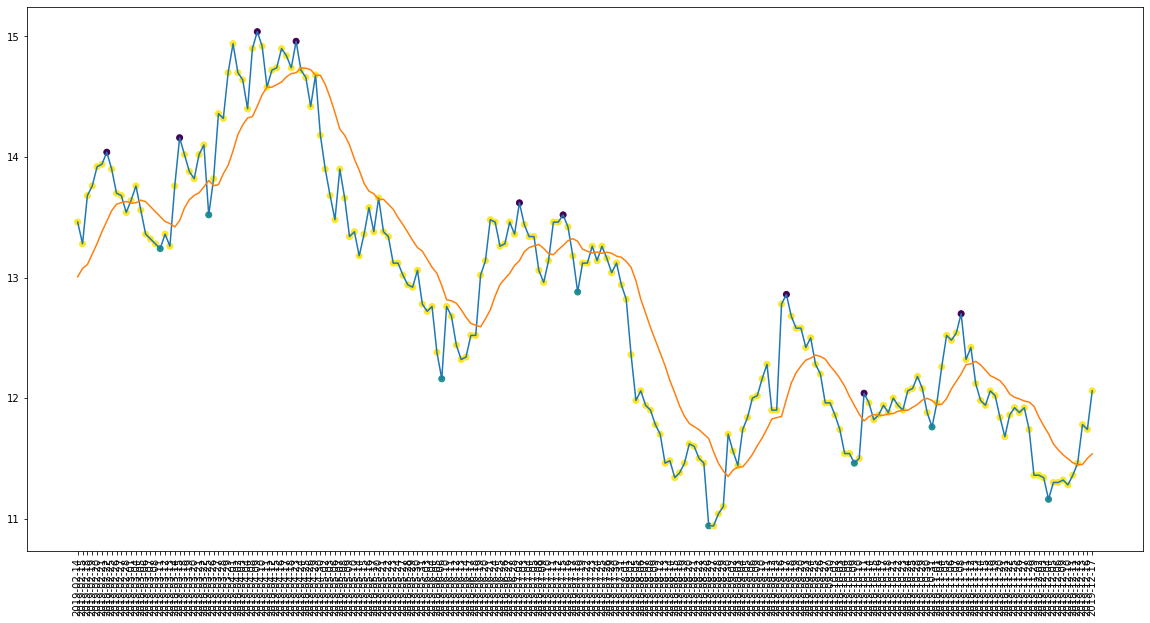

In [121]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [122]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 44
actual holds but predicted sell: 15
actual predicted holds: 135
Percentage buys correct: 25.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 69.58762886597938%
actual buys: 8
actual sells: 9
actual holds: 194


In [123]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 55.319148936170215%
Percentage sells correct: 76.47058823529412%
Percentage holds correct: 80.82191780821918%


In [124]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.239999771118164
Shares owned at the moment: 727
Cash capital at the moment: $2.8757602133773617


Price increase from previously bought: 6.655338997501015%
Share price: $14.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10268.886269587041


Share price: $13.68000030517578
Shares owned at the moment: 748
Cash capital at the moment: $8.106280687812614


Stop Loss Activated!

Share price: $13.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9839.635248331548


Share price: $13.18000030517578
Shares owned at the moment: 744
Cash capital at the moment: $6.748740656377777


Stop Loss Activated!

Share price: $12.779999732971193
Shares owned at the moment: 0
Cash capital at the mom

In [125]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [126]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-31,12.00,12.977839,-94.680831,-24968864.0,2.0
2020-02-03,11.86,12.805864,-97.959186,-90556668.0,1.0
2020-02-04,11.68,12.632654,-96.330278,-150958086.0,2.0
2020-02-05,11.80,12.504553,-86.842095,-75225791.0,2.0
2020-02-06,12.00,12.426930,-76.851850,12002801.0,2.0


In [127]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(213, 10, 4)

In [128]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [129]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3033 - accuracy: 0.6714 - mean_squared_error: 9.0286 - weighted_accuracy: 0.6714 - weighted_mean_squared_error: 9.0286
Test loss: 0.3032778799533844
Test accuracy: 0.67136150598526


In [130]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 24, 2: 147, 1: 42})

In [131]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [132]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,0,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


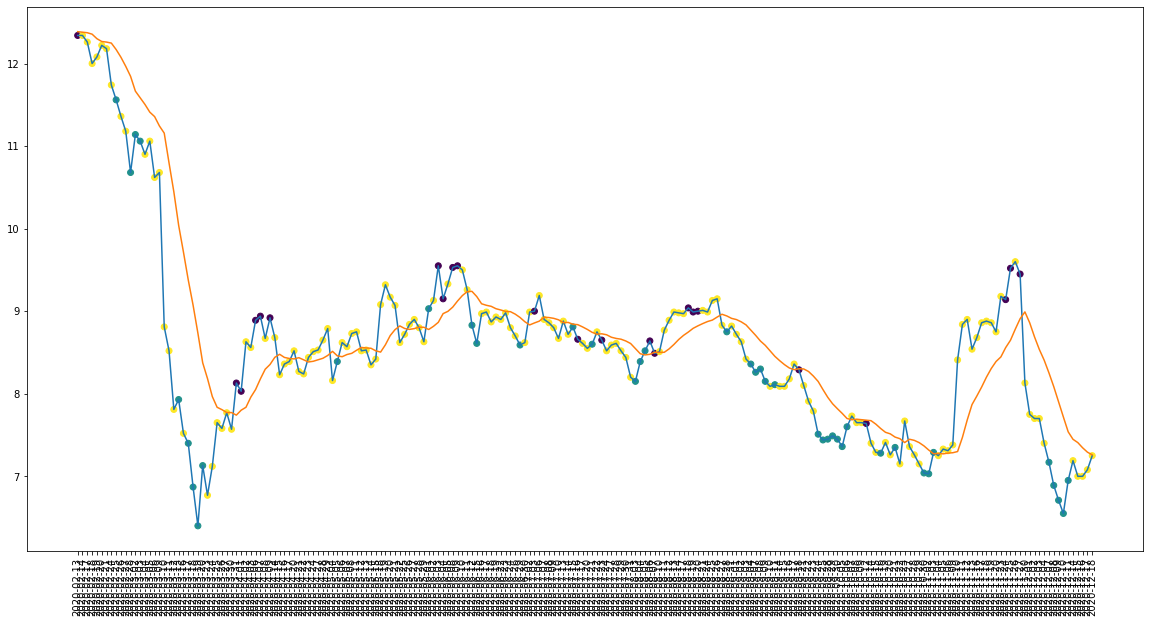

In [133]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

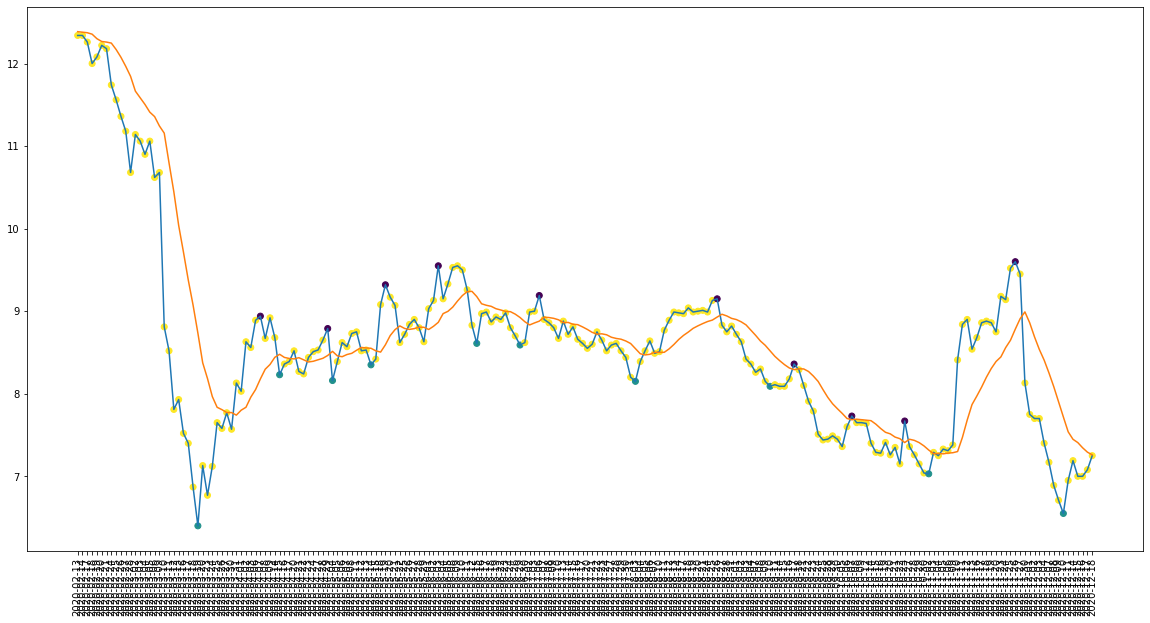

In [134]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [135]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 36
actual holds but predicted sell: 22
actual predicted holds: 135
Percentage buys correct: 60.0%
Percentage sells correct: 20.0%
Percentage holds correct: 69.94818652849742%
actual buys: 10
actual sells: 10
actual holds: 193


In [136]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 69.56521739130434%
Percentage holds correct: 83.6734693877551%


In [137]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.5600004196167
Shares owned at the moment: 862
Cash capital at the moment: $7.876657295702898


Stop Loss Activated!

Share price: $11.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9618.534729633806


Share price: $10.68000030517578
Shares owned at the moment: 898
Cash capital at the moment: $1.5201948323247052


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7891.144275611877


Share price: $7.929999828338622
Shares owned at the moment: 992
Cash capital at the moment: $2.951406368255448


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7442.27682749939


Share price: $7.400000095367432
Shares owned at the moment: 1002
Cash capital at the moment: $7.086031678438303


Stop Loss Activated!

Share price: $6.869999885559082
Shares owned at the moment: 0
Cash capital at the moment: $6871.89563232398


Share price: $6.869

In [138]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [139]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


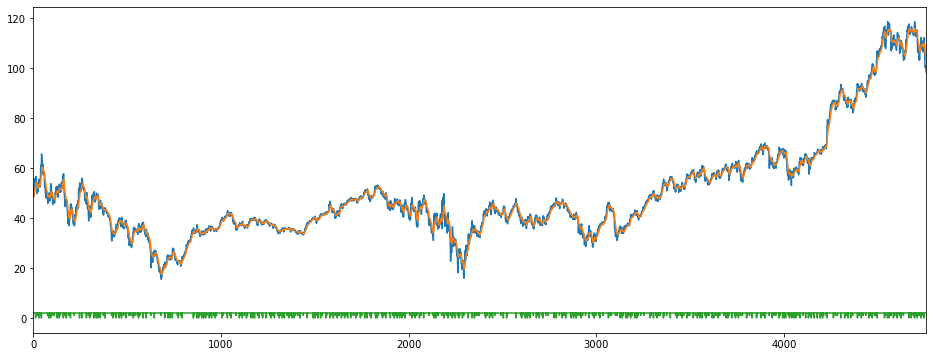

In [140]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [141]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [142]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(4750, 10, 4)

In [143]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [144]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [145]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [146]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [147]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2924 - accuracy: 0.4611 - mse: 0.4649 - weighted_accuracy: 0.3509 - weighted_mse: 0.5136 - val_loss: 0.2998 - val_accuracy: 0.0453 - val_mse: 0.3509 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3509
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2059 - accuracy: 0.3366 - mse: 0.7740 - weighted_accuracy: 0.5007 - weighted_mse: 0.7355 - val_loss: 0.2905 - val_accuracy: 0.0453 - val_mse: 0.3798 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3798
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1808 - accuracy: 0.2732 - mse: 1.0431 - weighted_accuracy: 0.5471 - weighted_mse: 0.9835 - val_loss: 0.2788 - val_accuracy: 0.0453 - val_mse: 0.4173 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4173
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1724 - accuracy: 0.2729 - mse: 1.2142 - weighted_accuracy: 0.5620 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1296 - accuracy: 0.4400 - mse: 1.8374 - weighted_accuracy: 0.7304 - weighted_mse: 1.7732 - val_loss: 0.1855 - val_accuracy: 0.3905 - val_mse: 1.8473 - val_weighted_accuracy: 0.3905 - val_weighted_mse: 1.8473
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1281 - accuracy: 0.4329 - mse: 1.8389 - weighted_accuracy: 0.7355 - weighted_mse: 1.7629 - val_loss: 0.1886 - val_accuracy: 0.3958 - val_mse: 1.9274 - val_weighted_accuracy: 0.3958 - val_weighted_mse: 1.9274
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.4708 - mse: 1.8480 - weighted_accuracy: 0.7476 - weighted_mse: 1.7854 - val_loss: 0.1981 - val_accuracy: 0.3411 - val_mse: 2.0715 - val_weighted_accuracy: 0.3411 - val_weighted_mse: 2.0715
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1267 - accuracy: 0.4363 - mse: 1.9063 - weighted_accuracy: 0.7389 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1013 - accuracy: 0.6189 - mse: 2.4453 - weighted_accuracy: 0.8359 - weighted_mse: 2.4129 - val_loss: 0.1645 - val_accuracy: 0.5758 - val_mse: 2.4499 - val_weighted_accuracy: 0.5758 - val_weighted_mse: 2.4499
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1005 - accuracy: 0.6195 - mse: 2.4719 - weighted_accuracy: 0.8419 - weighted_mse: 2.4263 - val_loss: 0.1661 - val_accuracy: 0.5695 - val_mse: 2.5777 - val_weighted_accuracy: 0.5695 - val_weighted_mse: 2.5777
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1014 - accuracy: 0.6350 - mse: 2.5190 - weighted_accuracy: 0.8381 - weighted_mse: 2.4906 - val_loss: 0.2025 - val_accuracy: 0.4579 - val_mse: 2.7027 - val_weighted_accuracy: 0.4579 - val_weighted_mse: 2.7027
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0971 - accuracy: 0.6355 - mse: 2.5229 - weighted_accuracy: 0.8496 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0753 - accuracy: 0.7463 - mse: 3.3780 - weighted_accuracy: 0.8997 - weighted_mse: 3.3085 - val_loss: 0.1896 - val_accuracy: 0.5653 - val_mse: 3.4716 - val_weighted_accuracy: 0.5653 - val_weighted_mse: 3.4716
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0750 - accuracy: 0.7613 - mse: 3.4408 - weighted_accuracy: 0.8976 - weighted_mse: 3.3624 - val_loss: 0.1665 - val_accuracy: 0.6337 - val_mse: 3.5980 - val_weighted_accuracy: 0.6337 - val_weighted_mse: 3.5980
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0741 - accuracy: 0.7463 - mse: 3.4614 - weighted_accuracy: 0.9054 - weighted_mse: 3.3732 - val_loss: 0.1721 - val_accuracy: 0.6253 - val_mse: 3.5040 - val_weighted_accuracy: 0.6253 - val_weighted_mse: 3.5040
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0728 - accuracy: 0.7626 - mse: 3.4667 - weighted_accuracy: 0.9076 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0538 - accuracy: 0.8468 - mse: 4.8554 - weighted_accuracy: 0.9365 - weighted_mse: 4.5814 - val_loss: 0.1855 - val_accuracy: 0.6726 - val_mse: 5.2665 - val_weighted_accuracy: 0.6726 - val_weighted_mse: 5.2665
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0522 - accuracy: 0.8492 - mse: 4.9598 - weighted_accuracy: 0.9411 - weighted_mse: 4.6494 - val_loss: 0.1802 - val_accuracy: 0.6737 - val_mse: 5.1584 - val_weighted_accuracy: 0.6737 - val_weighted_mse: 5.1584
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0542 - accuracy: 0.8363 - mse: 5.0382 - weighted_accuracy: 0.9344 - weighted_mse: 4.7713 - val_loss: 0.1833 - val_accuracy: 0.6779 - val_mse: 5.5106 - val_weighted_accuracy: 0.6779 - val_weighted_mse: 5.5106
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0517 - accuracy: 0.8476 - mse: 5.0647 - weighted_accuracy: 0.9443 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0388 - accuracy: 0.8921 - mse: 7.0400 - weighted_accuracy: 0.9587 - weighted_mse: 6.3652 - val_loss: 0.1931 - val_accuracy: 0.7526 - val_mse: 7.1025 - val_weighted_accuracy: 0.7526 - val_weighted_mse: 7.1025
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.8879 - mse: 7.0309 - weighted_accuracy: 0.9553 - weighted_mse: 6.3557 - val_loss: 0.1929 - val_accuracy: 0.7379 - val_mse: 7.6739 - val_weighted_accuracy: 0.7379 - val_weighted_mse: 7.6739
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.8955 - mse: 7.2175 - weighted_accuracy: 0.9562 - weighted_mse: 6.5197 - val_loss: 0.1929 - val_accuracy: 0.7463 - val_mse: 7.5217 - val_weighted_accuracy: 0.7463 - val_weighted_mse: 7.5217
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.8863 - mse: 7.1688 - weighted_accuracy: 0.9584 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0295 - accuracy: 0.9279 - mse: 9.6446 - weighted_accuracy: 0.9698 - weighted_mse: 8.3804 - val_loss: 0.2157 - val_accuracy: 0.7642 - val_mse: 9.8618 - val_weighted_accuracy: 0.7642 - val_weighted_mse: 9.8618
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9353 - mse: 9.7134 - weighted_accuracy: 0.9763 - weighted_mse: 8.4036 - val_loss: 0.2139 - val_accuracy: 0.7789 - val_mse: 10.0755 - val_weighted_accuracy: 0.7789 - val_weighted_mse: 10.0755
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9321 - mse: 9.6818 - weighted_accuracy: 0.9752 - weighted_mse: 8.3974 - val_loss: 0.2086 - val_accuracy: 0.7884 - val_mse: 10.6595 - val_weighted_accuracy: 0.7884 - val_weighted_mse: 10.6595
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9271 - mse: 9.7421 - weighted_accuracy: 0.973

In [148]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2429046481847763
Test accuracy: 0.730526328086853


In [149]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.8694468 -3.102659   2.400902 ]
 [-7.3567753 -2.2510736  2.4100606]
 [ 0.2773199 -5.819832  -0.7968956]
 ...
 [-5.856303  -3.9284337  4.226081 ]
 [-3.5072305 -5.7985706  2.6530435]
 [-7.142729  -4.546888   3.3210452]]


Counter({2: 750, 0: 108, 1: 92})

In [150]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 866, 0: 41, 1: 43})

In [151]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 33
actual holds but predicted buy: 85
actual holds but predicted sell: 100
actual predicted holds: 681
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 17.073170731707318%
Percentage holds correct: 78.63741339491916%
actual buys: 43
actual sells: 41
actual holds: 866


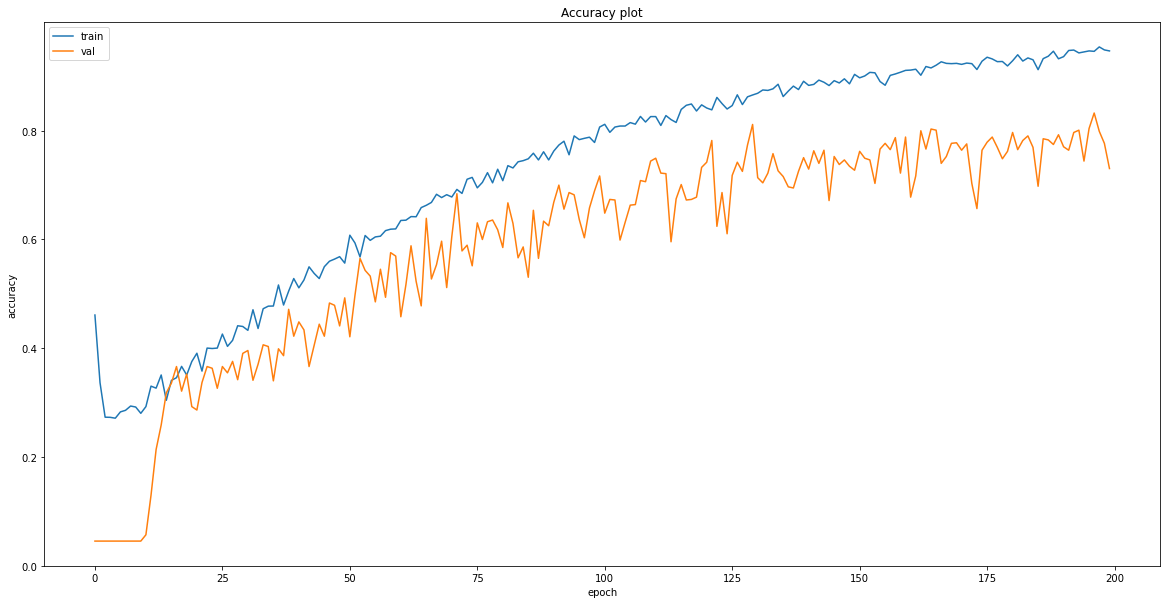

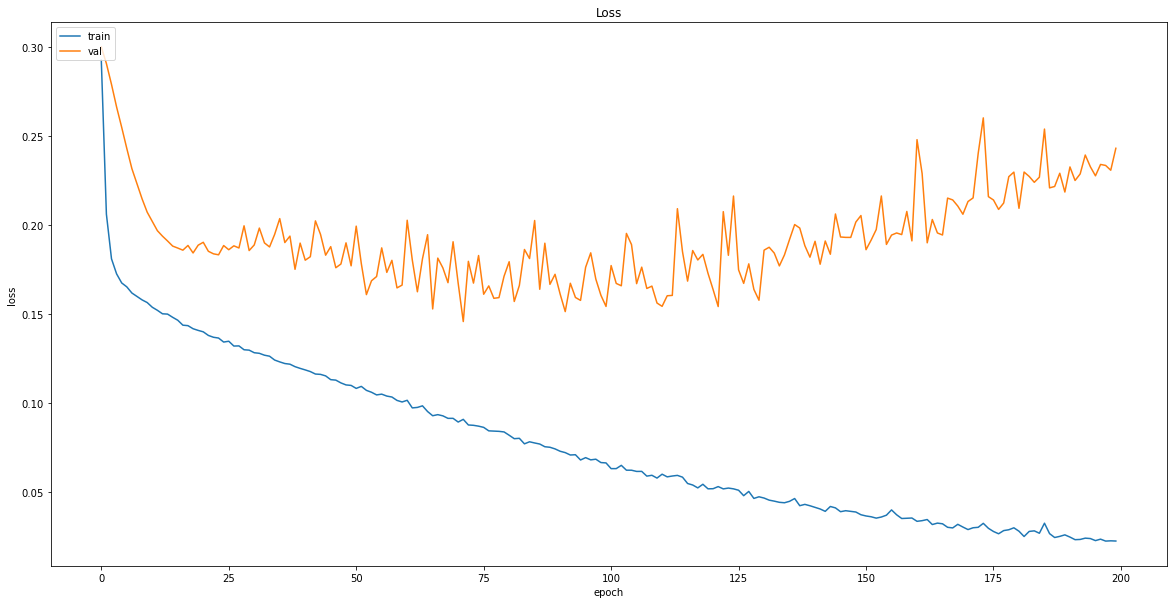

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [153]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [156]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,103.879997,102.341518,-16.190536,93054100.0,2.0
2019-01-30,104.169998,102.622823,-14.439357,102797400.0,2.0
2019-01-31,104.410004,102.897774,-12.499914,115323700.0,2.0
2019-02-01,103.500000,102.990424,-26.204790,97803100.0,2.0
2019-02-04,103.879997,103.127281,-20.481939,110803900.0,2.0


In [157]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(218, 10, 4)

In [158]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [159]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2058 - accuracy: 0.7523 - mean_squared_error: 12.3447 - weighted_accuracy: 0.7523 - weighted_mean_squared_error: 12.3447
Test loss: 0.20575623214244843
Test accuracy: 0.752293586730957


In [160]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 1: 19, 0: 24})

In [161]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [162]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


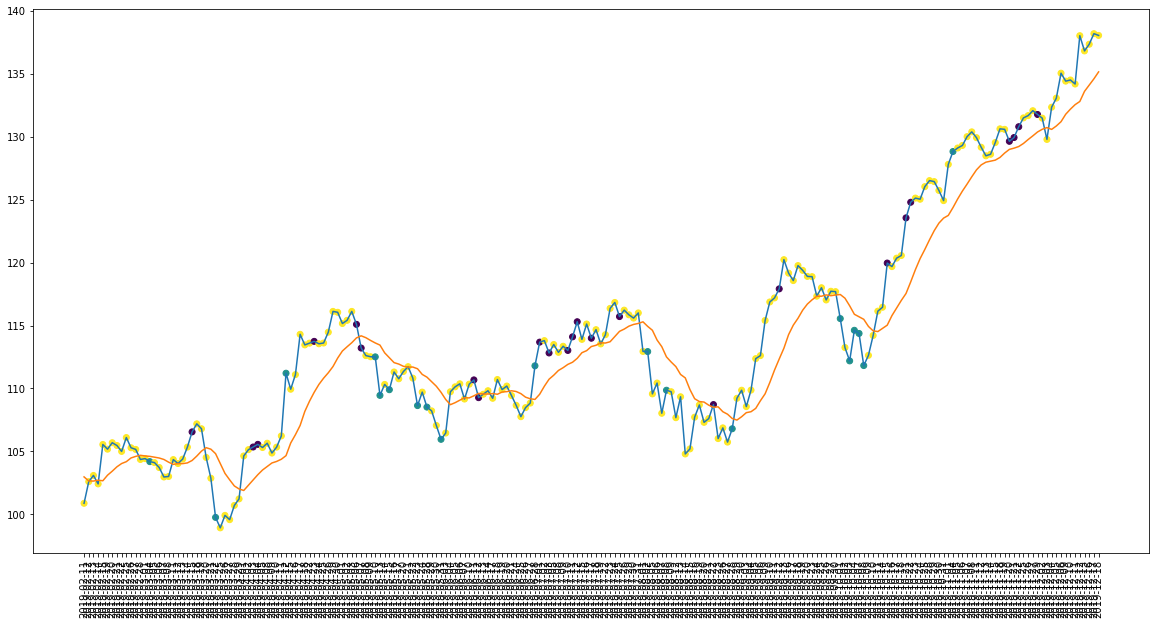

In [163]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

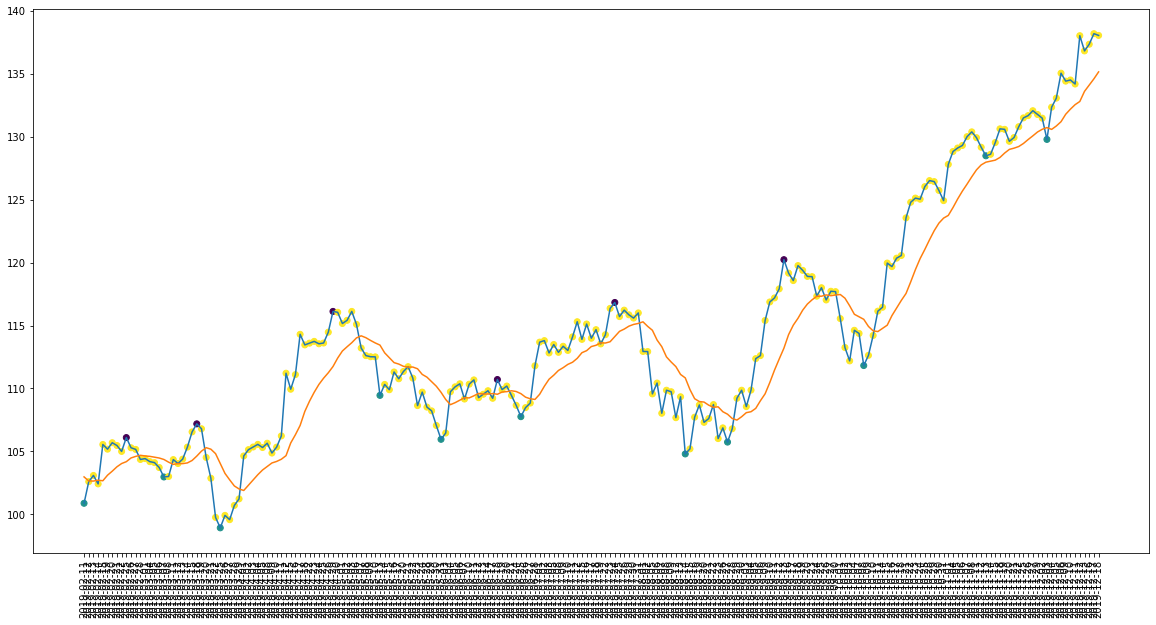

In [164]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [165]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 16
actual holds but predicted sell: 24
actual predicted holds: 161
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 0.0%
Percentage holds correct: 80.09950248756219%
actual buys: 11
actual sells: 6
actual holds: 201


In [166]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 42.10526315789474%
Percentage sells correct: 45.833333333333336%
Percentage holds correct: 85.63218390804597%


In [167]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.19000244140624
Shares owned at the moment: 95
Cash capital at the moment: $74.73012992859003


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9525.868032312395


Share price: $99.76000213623048
Shares owned at the moment: 95
Cash capital at the moment: $22.60552881240801


Price increase from previously bought: 5.313831448468709%
Share price: $105.3499984741211
Shares owned at the moment: 0
Cash capital at the moment: $10003.332696752548


Share price: $111.20999908447266
Shares owned at the moment: 89
Cash capital at the moment: $78.4241309585559


Stop Loss Activated!

Share price: $107.05999755859376
Shares owned at the moment: 0
Cash capital at the moment: $9580.560979270935


Share price: $105.95999908447266
Shares owned at the moment: 90
Cash capital at the moment: $17.935961894987486


Price increase from previously bought: 6.991542687023999%
Share price: $113.68000030517578
Shares owned at the m

In [168]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [169]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-29,134.429993,135.764759,-57.285148,1917800.0,2.0
2020-01-30,134.229996,135.528641,-59.095077,-7408200.0,2.0
2020-01-31,135.889999,135.584235,-44.072403,1640700.0,2.0
2020-02-03,132.360001,135.088199,-76.018128,-11144500.0,2.0
2020-02-04,133.369995,134.823860,-66.877896,-1123400.0,2.0


In [170]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(219, 10, 4)

In [171]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [172]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2748 - accuracy: 0.7443 - mean_squared_error: 10.2264 - weighted_accuracy: 0.7443 - weighted_mean_squared_error: 10.2264
Test loss: 0.2747834026813507
Test accuracy: 0.7442922592163086


In [173]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 0: 23, 1: 21})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [175]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,0,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,0,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,0,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,0,2


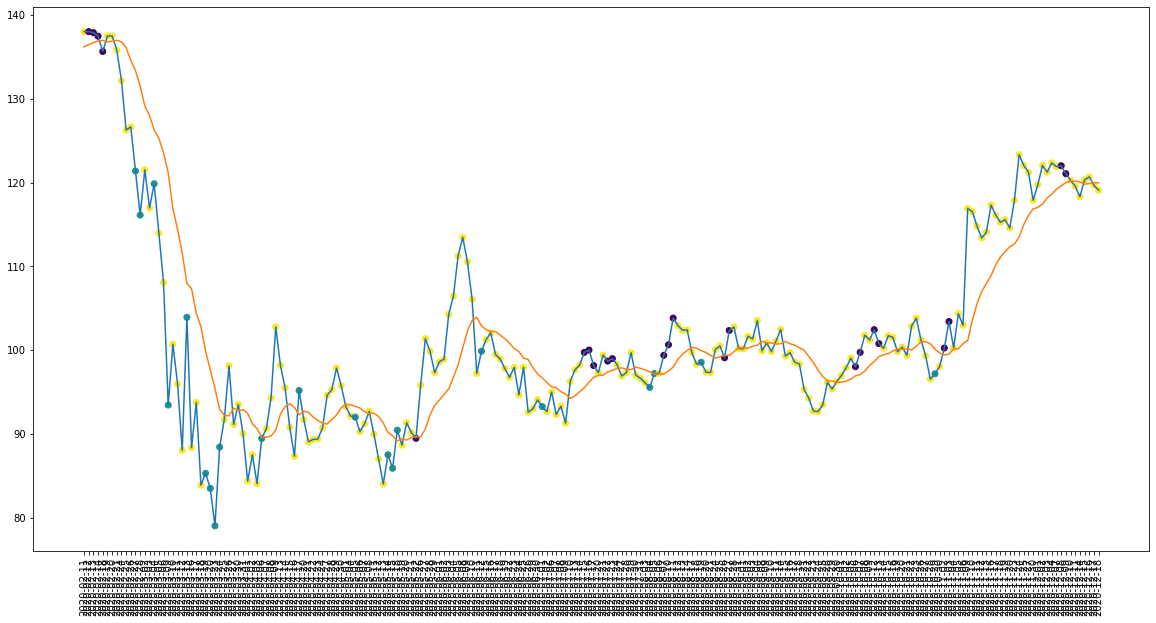

In [176]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

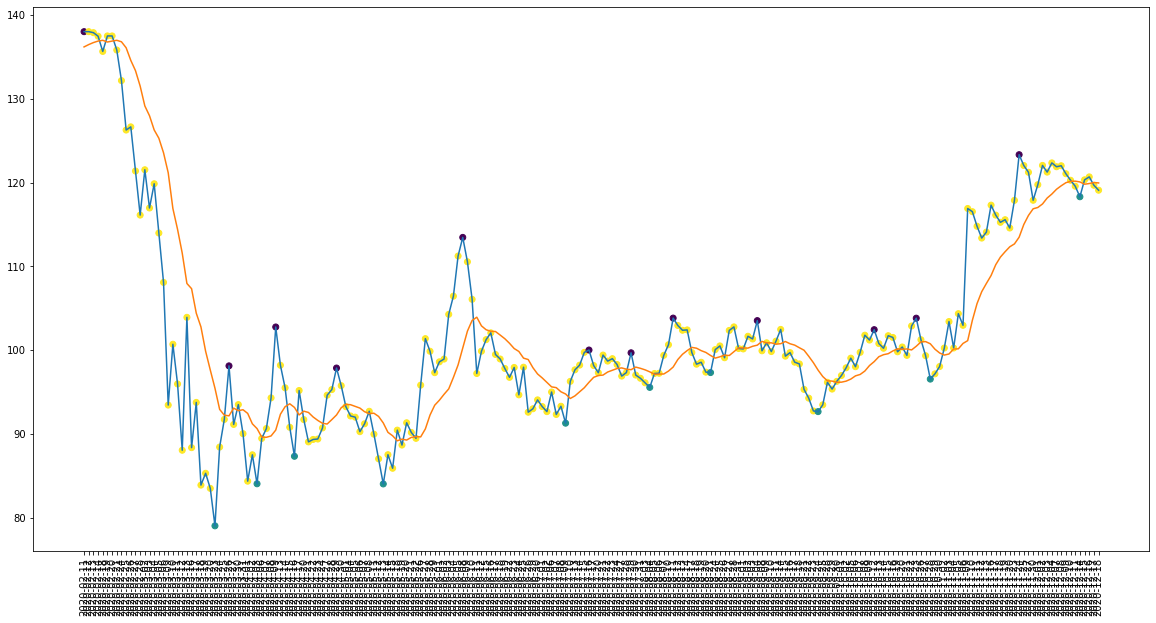

In [177]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [178]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 19
actual holds but predicted sell: 20
actual predicted holds: 158
Percentage buys correct: 20.0%
Percentage sells correct: 25.0%
Percentage holds correct: 80.20304568527919%
actual buys: 10
actual sells: 12
actual holds: 197


In [179]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 56.52173913043478%
Percentage holds correct: 82.75862068965517%


In [180]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $121.37000274658205
Shares owned at the moment: 82
Cash capital at the moment: $20.29083916091622


Stop Loss Activated!

Share price: $116.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9515.12808407211


Share price: $116.11000061035156
Shares owned at the moment: 81
Cash capital at the moment: $84.35453199767835


Stop Loss Activated!

Share price: $108.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $8814.75985990524


Share price: $93.44000244140624
Shares owned at the moment: 94
Cash capital at the moment: $7.245389781950507


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8261.184750858305


Share price: $103.91000366210938
Shares owned at the moment: 79
Cash capital at the moment: $29.72001325607016


Stop Loss Activated!

Share price: $88.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $6990.963851341245


Share price: $85.

In [181]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [182]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


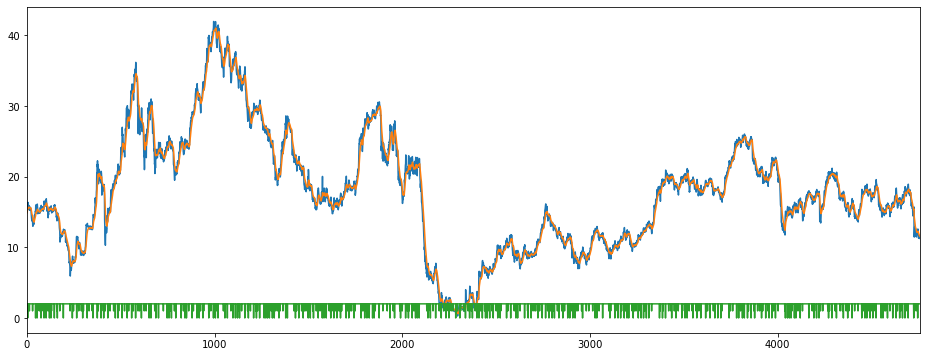

In [183]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [184]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [185]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(4750, 10, 4)

In [186]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [187]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [188]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [189]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [190]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2953 - accuracy: 0.4624 - mse: 0.4644 - weighted_accuracy: 0.3443 - weighted_mse: 0.5169 - val_loss: 0.2996 - val_accuracy: 0.0463 - val_mse: 0.3510 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3510
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2086 - accuracy: 0.3011 - mse: 0.7864 - weighted_accuracy: 0.4652 - weighted_mse: 0.7376 - val_loss: 0.2909 - val_accuracy: 0.0463 - val_mse: 0.3816 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3816
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1851 - accuracy: 0.2645 - mse: 1.0361 - weighted_accuracy: 0.5136 - weighted_mse: 0.9656 - val_loss: 0.2794 - val_accuracy: 0.0463 - val_mse: 0.4199 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.4199
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1763 - accuracy: 0.2713 - mse: 1.2039 - weighted_accuracy: 0.5307 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1305 - accuracy: 0.4242 - mse: 1.7507 - weighted_accuracy: 0.7360 - weighted_mse: 1.6684 - val_loss: 0.1834 - val_accuracy: 0.4189 - val_mse: 1.8058 - val_weighted_accuracy: 0.4189 - val_weighted_mse: 1.8058
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1311 - accuracy: 0.4468 - mse: 1.7588 - weighted_accuracy: 0.7388 - weighted_mse: 1.6898 - val_loss: 0.1869 - val_accuracy: 0.4168 - val_mse: 1.7985 - val_weighted_accuracy: 0.4168 - val_weighted_mse: 1.7985
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1295 - accuracy: 0.4539 - mse: 1.7684 - weighted_accuracy: 0.7451 - weighted_mse: 1.6956 - val_loss: 0.2054 - val_accuracy: 0.3368 - val_mse: 1.8974 - val_weighted_accuracy: 0.3368 - val_weighted_mse: 1.8974
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1289 - accuracy: 0.4284 - mse: 1.8363 - weighted_accuracy: 0.7430 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1053 - accuracy: 0.6087 - mse: 2.3271 - weighted_accuracy: 0.8164 - weighted_mse: 2.3756 - val_loss: 0.1975 - val_accuracy: 0.4579 - val_mse: 2.5055 - val_weighted_accuracy: 0.4579 - val_weighted_mse: 2.5055
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1057 - accuracy: 0.6139 - mse: 2.3428 - weighted_accuracy: 0.8292 - weighted_mse: 2.3811 - val_loss: 0.1797 - val_accuracy: 0.5368 - val_mse: 2.4077 - val_weighted_accuracy: 0.5368 - val_weighted_mse: 2.4077
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1032 - accuracy: 0.6168 - mse: 2.3887 - weighted_accuracy: 0.8376 - weighted_mse: 2.4412 - val_loss: 0.1788 - val_accuracy: 0.5211 - val_mse: 2.4005 - val_weighted_accuracy: 0.5211 - val_weighted_mse: 2.4005
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1029 - accuracy: 0.6187 - mse: 2.3849 - weighted_accuracy: 0.8273 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.7353 - mse: 3.1359 - weighted_accuracy: 0.8774 - weighted_mse: 3.2922 - val_loss: 0.1717 - val_accuracy: 0.6105 - val_mse: 3.3352 - val_weighted_accuracy: 0.6105 - val_weighted_mse: 3.3352
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0829 - accuracy: 0.7076 - mse: 3.2223 - weighted_accuracy: 0.8782 - weighted_mse: 3.3904 - val_loss: 0.1726 - val_accuracy: 0.6147 - val_mse: 3.1756 - val_weighted_accuracy: 0.6147 - val_weighted_mse: 3.1756
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0795 - accuracy: 0.7384 - mse: 3.2549 - weighted_accuracy: 0.8895 - weighted_mse: 3.4191 - val_loss: 0.1700 - val_accuracy: 0.6284 - val_mse: 3.3348 - val_weighted_accuracy: 0.6284 - val_weighted_mse: 3.3348
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0793 - accuracy: 0.7503 - mse: 3.2990 - weighted_accuracy: 0.8865 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.8097 - mse: 4.4202 - weighted_accuracy: 0.9265 - weighted_mse: 4.6168 - val_loss: 0.1930 - val_accuracy: 0.6200 - val_mse: 4.3739 - val_weighted_accuracy: 0.6200 - val_weighted_mse: 4.3739
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.8079 - mse: 4.5001 - weighted_accuracy: 0.9168 - weighted_mse: 4.6978 - val_loss: 0.1683 - val_accuracy: 0.6863 - val_mse: 4.7867 - val_weighted_accuracy: 0.6863 - val_weighted_mse: 4.7867
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0623 - accuracy: 0.8116 - mse: 4.5325 - weighted_accuracy: 0.9199 - weighted_mse: 4.7177 - val_loss: 0.1795 - val_accuracy: 0.6526 - val_mse: 4.7324 - val_weighted_accuracy: 0.6526 - val_weighted_mse: 4.7324
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0595 - accuracy: 0.8155 - mse: 4.5896 - weighted_accuracy: 0.9214 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0463 - accuracy: 0.8813 - mse: 6.1184 - weighted_accuracy: 0.9510 - weighted_mse: 6.2246 - val_loss: 0.1737 - val_accuracy: 0.7295 - val_mse: 6.4699 - val_weighted_accuracy: 0.7295 - val_weighted_mse: 6.4699
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.8755 - mse: 6.1659 - weighted_accuracy: 0.9525 - weighted_mse: 6.2995 - val_loss: 0.2129 - val_accuracy: 0.6789 - val_mse: 6.7687 - val_weighted_accuracy: 0.6789 - val_weighted_mse: 6.7687
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.8692 - mse: 6.1455 - weighted_accuracy: 0.9520 - weighted_mse: 6.2660 - val_loss: 0.1736 - val_accuracy: 0.7432 - val_mse: 6.2671 - val_weighted_accuracy: 0.7432 - val_weighted_mse: 6.2671
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0463 - accuracy: 0.8718 - mse: 6.3250 - weighted_accuracy: 0.9475 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0367 - accuracy: 0.9074 - mse: 7.8218 - weighted_accuracy: 0.9606 - weighted_mse: 7.7607 - val_loss: 0.1978 - val_accuracy: 0.7516 - val_mse: 7.5699 - val_weighted_accuracy: 0.7516 - val_weighted_mse: 7.5699
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9129 - mse: 7.9322 - weighted_accuracy: 0.9680 - weighted_mse: 7.7636 - val_loss: 0.1932 - val_accuracy: 0.7611 - val_mse: 8.1786 - val_weighted_accuracy: 0.7611 - val_weighted_mse: 8.1786
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9200 - mse: 8.0502 - weighted_accuracy: 0.9706 - weighted_mse: 7.9097 - val_loss: 0.2215 - val_accuracy: 0.7021 - val_mse: 8.1908 - val_weighted_accuracy: 0.7021 - val_weighted_mse: 8.1908
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9121 - mse: 8.2246 - weighted_accuracy: 0.9677 - 

In [191]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21650832891464233
Test accuracy: 0.7463157773017883


In [192]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.9273727  -2.1847653   0.35952085]
 [-1.5430264  -0.3252834  -1.0298803 ]
 [-0.94209    -4.635562    0.58695006]
 ...
 [-0.95992506 -2.0975738  -0.43516216]
 [-1.604456   -4.9045835   0.9942724 ]
 [-1.4279488  -2.3358552   0.21968563]]


Counter({2: 769, 1: 100, 0: 81})

In [193]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 44})

In [194]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 35
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 94
actual holds but predicted sell: 72
actual predicted holds: 697
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 80.76477404403245%
actual buys: 44
actual sells: 43
actual holds: 863


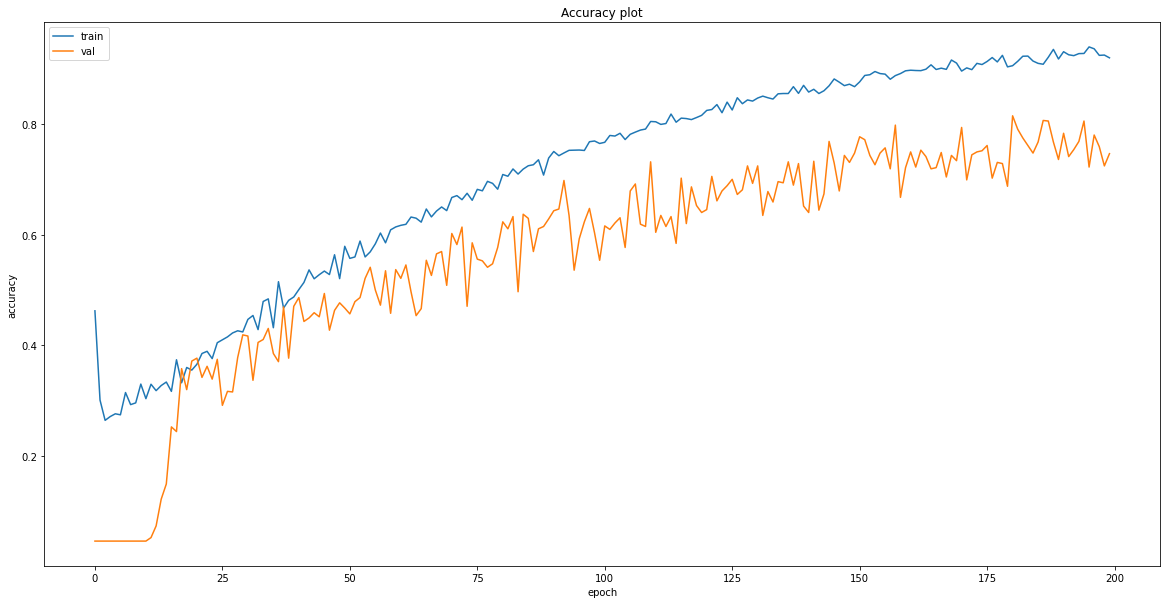

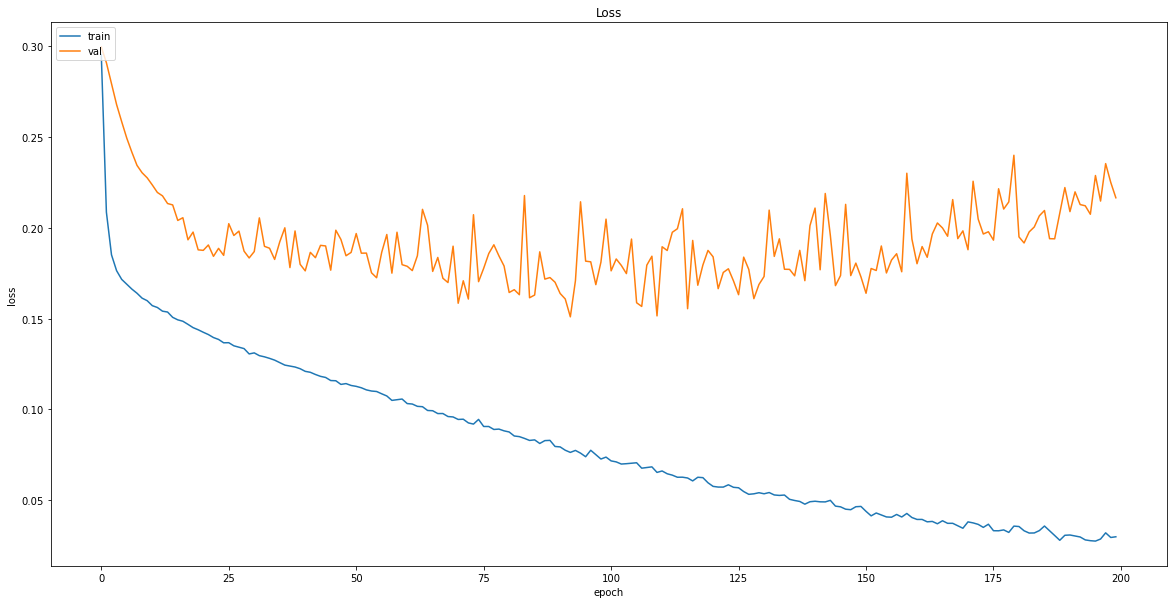

In [195]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [196]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [197]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,14.43,13.836690,-16.988400,21013100.0,2.0
2019-01-30,14.33,13.912584,-22.131150,19773800.0,2.0
2019-01-31,14.59,14.016802,-11.475401,20659500.0,2.0
2019-02-01,14.78,14.134217,-4.017864,22103800.0,2.0
2019-02-04,14.92,14.255106,-6.278041,23682100.0,0.0


In [198]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(218, 10, 4)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.7798 - mean_squared_error: 9.4967 - weighted_accuracy: 0.7798 - weighted_mean_squared_error: 9.4967
Test loss: 0.20528800785541534
Test accuracy: 0.7798165082931519


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 182, 0: 22, 1: 14})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,2,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


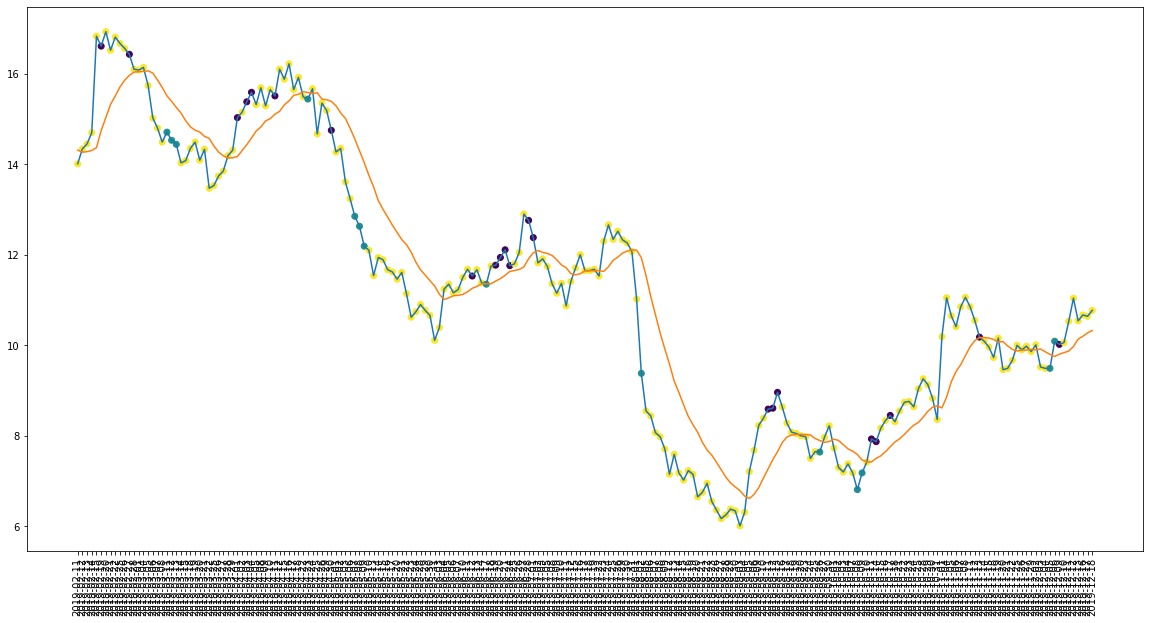

In [204]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

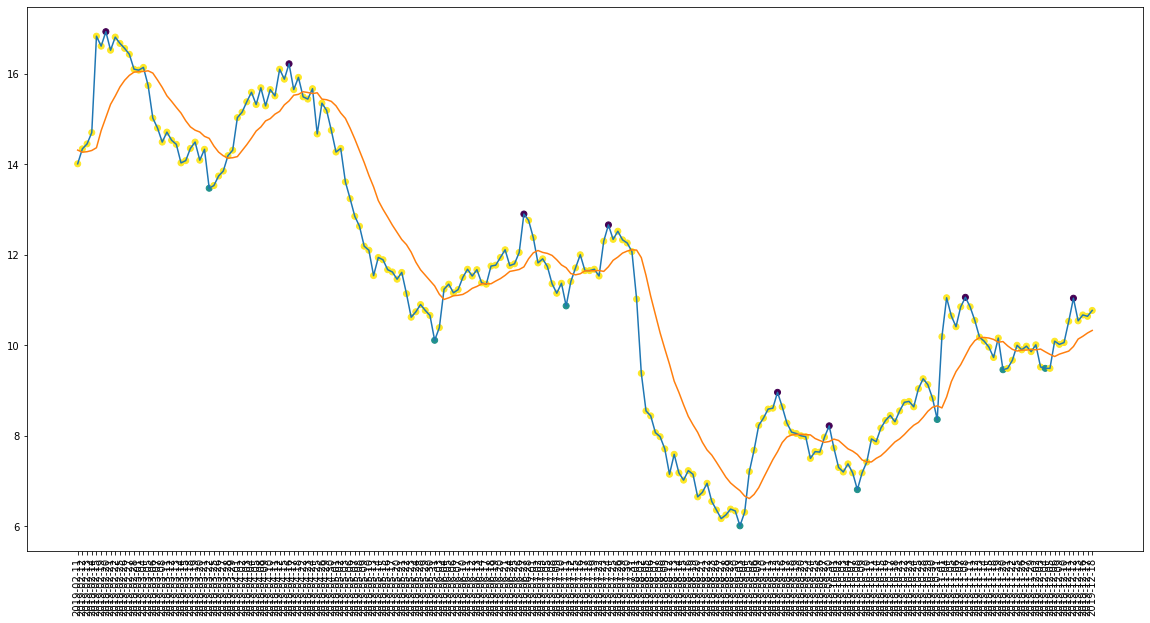

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [206]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 13
actual holds but predicted sell: 21
actual predicted holds: 168
Percentage buys correct: 12.5%
Percentage sells correct: 12.5%
Percentage holds correct: 83.16831683168317%
actual buys: 8
actual sells: 8
actual holds: 202


In [207]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 50.0%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 85.0828729281768%


In [208]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.710000038146973
Shares owned at the moment: 677
Cash capital at the moment: $13.943631603478934


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9486.133098822118


Share price: $15.4399995803833
Shares owned at the moment: 612
Cash capital at the moment: $10.867836333753075


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8964.218272897244


Share price: $12.850000381469727
Shares owned at the moment: 695
Cash capital at the moment: $8.908444546699684


Stop Loss Activated!

Share price: $12.1899995803833
Shares owned at the moment: 0
Cash capital at the moment: $8457.660016215086


Share price: $12.1899995803833
Shares owned at the moment: 691
Cash capital at the moment: $11.20625946760265


Stop Loss Activated!

Share price: $11.539999961853027
Shares owned at the moment: 0
Cash capital at the moment: $7963.417348180533


Share price:

In [209]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [210]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-29,9.56,9.554791,-45.714255,-464900.0,2.0
2020-01-30,9.44,9.537131,-47.107490,-1769800.0,2.0
2020-01-31,9.41,9.517572,-49.586807,-2999800.0,1.0
2020-02-03,9.24,9.474869,-63.636399,-4264900.0,2.0
2020-02-04,9.45,9.471043,-51.851894,-2731100.0,2.0


In [211]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(219, 10, 4)

In [212]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [213]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.7626 - mean_squared_error: 8.9323 - weighted_accuracy: 0.7626 - weighted_mean_squared_error: 8.9323
Test loss: 0.17991498112678528
Test accuracy: 0.7625570893287659


In [214]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 0: 19, 1: 17})

In [215]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [216]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,0,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,1,2


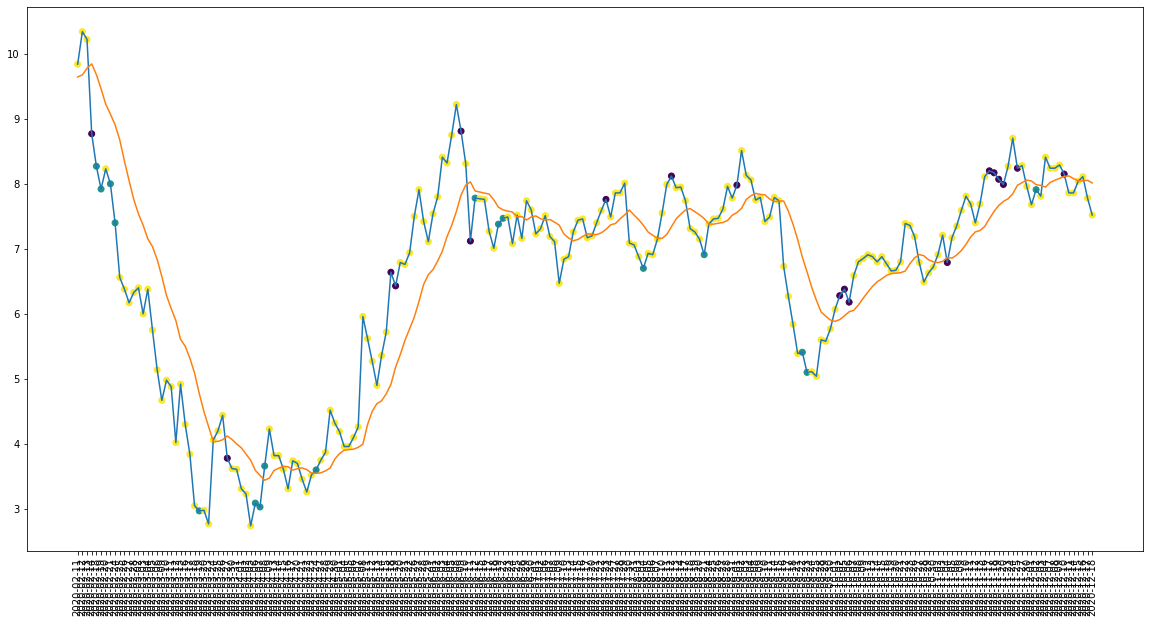

In [217]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

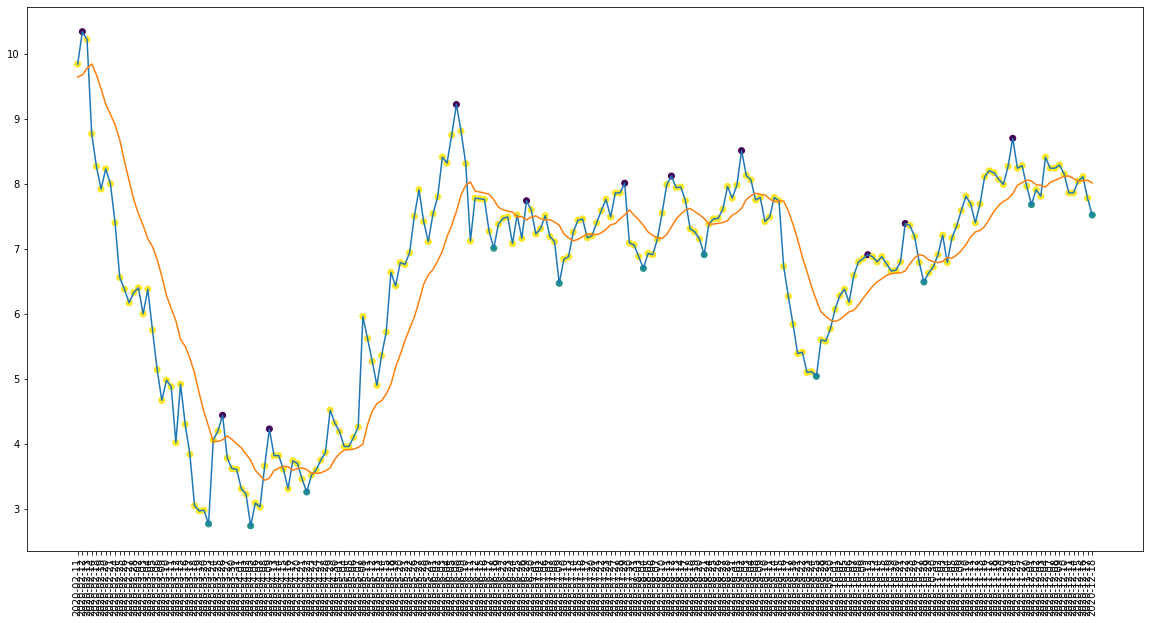

In [218]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [219]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 18
actual predicted holds: 164
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 83.248730964467%
actual buys: 11
actual sells: 11
actual holds: 197


In [220]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 63.1578947368421%
Percentage holds correct: 85.16483516483517%


In [221]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.270000457763674
Shares owned at the moment: 1205
Cash capital at the moment: $7.244734377858549


Stop Loss Activated!

Share price: $7.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9524.599926059243


Share price: $7.920000076293945
Shares owned at the moment: 1199
Cash capital at the moment: $2.4056143312427594


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $8850.606078362343


Share price: $7.400000095367432
Shares owned at the moment: 1192
Cash capital at the moment: $5.548764371749712


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $7803.565016352531


Share price: $2.970000028610228
Shares owned at the moment: 2620
Cash capital at the moment: $0.7660911875964302


Stop Loss Activated!

Share price: $2.7699999809265137
Shares owned at the moment: 0
Cash capital at the moment: $7238.208191352486


Share pri

In [222]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
